In [68]:
library(glmnet)
library(matrixStats)
library(abind)
library(pracma)
library(matrixcalc)
library(TCA)
library(MCMCpack)
library(ggplot2)

In [38]:
generate_params <- function(cell_her=TRUE,gene_cor=FALSE,bulk_her=FALSE,seed=1,N=5000,M=100,herr_arr=c(),D=20,pslab=0.5,her=0.05,her_bulk=0.8){
    set.seed(1)
    if(length(herr_arr)!=0){
        M = length(herr_arr)
    }else{
        M = M
    }
    K = 4
    N = N
    pc_num = 2
    # cis_snps_nums = floor(runif(M, min = 150, max = 400))
    D = D
    cis_snps_nums = array(D,M)
    sigma_g = 0.01
    sigma_z = 0.1
    sigma_gamma = 0.1
    if(gene_cor){ # varing genetic correlation across genes
        corr_seq = seq(from=0,to=pslab,length.out=M)
    }else{
        corr_seq = seq(from=0,to=0,length.out=M)
    }
    pslab = matrix(pslab,nrow=M,ncol=K)
    corr_matrix = lapply(1:M,function(x) matrix(corr_seq[x],nrow=K,ncol=K))
    for(i in 1:M){
        diag(corr_matrix[[i]])=1
    }
    
    if(cell_her){ # varing heribility across genes
        heritibility_cell_specific = do.call(rbind,lapply(1:K,function(x) herr_arr))
    }else{
        heritibility_cell_specific = matrix(her,nrow=K,ncol=M)
    }
    
    if(bulk_her){ # varing bulk heritibility across genes
        heritibility_bulk = seq(from=0.1,to=her_bulk,length.out=M)
    }else{
        heritibility_bulk = array(her_bulk,M)
    }
        
    MAF = lapply(1:length(cis_snps_nums),function(x) runif(cis_snps_nums[x],min=0.1,max=0.5))
    id_name = sapply(1:N, function(x) paste('SAMPLE',toString(x),sep = ''))
    cell_type_name=sapply(1:K, function(x) paste('Cell_type',x,sep = ''))
    
    ### generate C1 and C2
    male = matrix(rbinom(N, 1, 0.5),nrow=N)
    smoking = matrix(rbinom(N, 2, 0.2),nrow=N)
    smoking = (smoking - min(smoking))/(max(smoking))
    age = matrix(sapply(sapply(rnorm(N,50,20), function(x) floor(x)), function(x)  if (x<0){x=20} else{x=x}),nrow=N) 
    age = (age-min(age))/(max(age)-min(age))
    c1 = scale(cbind(male, smoking, age))
    c2 = scale(matrix(rnorm(N*pc_num), nrow=N))
                            
    rownames(c1) = id_name
    colnames(c1) = c('male','smoking','age')
    rownames(c2) = id_name
    colnames(c2) = sapply(1:pc_num, function(x) paste('PC',toString(x),sep = ''))
                          
    p1 = dim(c1)[2]
    var_beta = heritibility_cell_specific*(p1*sigma_gamma^2+sigma_z^2)/(1-heritibility_cell_specific)/D
    
    # cell type proportion, from the real data estimated
    W_alpha = c(26.553683792256,17.6621467979005,4.48671525658667,1.56874856517803)#,0.178797663350679)
    #W_alpha = 50.4500920752719
    W_xsi = c(0.526335685426257,0.350091468050216,0.088933737720289,0.0310950585152043,0.00354405028803339)
    if(K <= length(W_alpha)){
        W = rdirichlet(N, W_alpha[1:K])
    }else{ #more cell type prop
        W = rdirichlet(N, runif(K, 0, 1))
    }
    colnames(W) = cell_type_name
    rownames(W) = id_name
    
    alpha = W_alpha
    alpha_0 = sum(alpha)
    alpha_tilde = alpha/alpha_0
    m2_alpha = alpha_tilde %*% t(alpha_tilde)*alpha_0/(alpha_0+1)
    diag(m2_alpha) = alpha_tilde*(1-alpha_tilde)/(alpha_0+1)+alpha_tilde^2
    
    return(list(
        'M'=M,'K'=K,'N'=N,'pc_num'=pc_num,'D'=D,'id_name'=id_name,'cell_name'=cell_type_name,
        'her'=heritibility_cell_specific,'her_bulk'=heritibility_bulk,'pslab'=pslab,
        'MAF'=MAF,'c1'=c1,'c2'=c2,'W'=W,'sigma_gamma'=sigma_gamma,'sigma_g'=sigma_g,'m2_alpha'=m2_alpha,
        'sigma_z'=sigma_z,'beta_cor'=corr_matrix,'var_beta'=var_beta,'W_alpha'=W_alpha[1:K]))
}

In [42]:
one_gene <- function(par,g,seed=1){
    set.seed(seed)
    cell_type = par$K
    n_snps = par$D
    her = par$her[,g]
    cor = par$beta_cor[[g]]
    pslab = par$pslab[g,]
    var_beta = par$var_beta[,g]
    maf = par$MAF[[g]]
    dummy_var = 10
    
    var_matrix=sqrt(var_beta%*%t(var_beta))
    Sigma_beta = cor*var_matrix/(1-pslab)^2
    diag(Sigma_beta) = diag(Sigma_beta) *(1-pslab)
    beta_ = mvrnorm(n_snps,mu=rep(0,params$K),Sigma=Sigma_beta,tol=1e-4,empirical=TRUE)
    rmask = do.call(rbind,lapply(1:cell_type,function(x) rbinom(n_snps,1,1-pslab[x])))
    beta = t(beta_)*rmask

    X = t(do.call(rbind,lapply(1:n_snps,function(x) rbinom(par$N,2,maf[x]))))
    colnames(X) = sapply(1:n_snps, function(x) paste('G',g,'_SNP',toString(x),sep = ''))
    rownames(X) = par$id_name
    X = scale(X)
    # enforce variance of samples by adjusting sd of beta
    xbeta_var = n_snps*var_beta[1]
    beta = do.call(rbind,
                      lapply(1:cell_type,function(x) beta[x,]*(sqrt(xbeta_var)/sd(X %*% beta[x,]))))

    mu_z = X%*%t(beta)
    epsilon_z = array(rnorm(par$N*cell_type,mean=0,sd=par$sigma_z), c(par$N,cell_type))
    epsilon_z = apply(epsilon_z,2,function(x) x*par$sigma_z/sd(x))
    gamma_c1 = do.call(rbind,lapply(1:cell_type,function(x) rnorm(dim(par$c1)[2],mean=0,sd=par$sigma_gamma)))     # enforce variance of samples by adjusting sd of gamma_c1
    # enforce the c1_gamma variance
    c1gamma_var = dim(par$c1)[2]*(par$sigma_gamma)^2
    gamma_c1 = do.call(rbind,
                       lapply(1:cell_type,function(x) gamma_c1[x,]*(sqrt(c1gamma_var)/sd(par$c1 %*% gamma_c1[x,]))))
    c1_gamma = par$c1 %*% t(gamma_c1)

    Z = epsilon_z + mu_z + c1_gamma
    rownames(Z) = par$id_name
    colnames(Z) = par$cell_name
    
    ### Generate Gene expressions
    G = rowSums((par$W)*Z)
    epsilon_G = rnorm(par$N,mean=0,sd=par$sigma_g)
    epsilon_G = epsilon_G*par$sigma_g/sd(epsilon_G)
    
    # use bulk level heritability to calculate sigma_gamma
    bulk_her_nom = sum(hadamard.prod(par$m2_alpha,var(mu_z)))
    bulk_her_denom = sum(hadamard.prod(par$m2_alpha,var(Z)))+var(epsilon_G)
    bulk_her_val = par$her_bulk[g]*her[1]
    sd_gamma_c2 = sqrt((bulk_her_nom/bulk_her_val-bulk_her_denom)/par$pc_num)
    
    gamma_c2 = matrix(rnorm(par$pc_num,mean=0,sd=sd_gamma_c2),nrow=par$pc_num,ncol=1)
    c2gamma_var = par$pc_num * (sd_gamma_c2)^2
    gamma_c2 = gamma_c2*(sqrt(c2gamma_var)/sd(par$c2%*%gamma_c2))
    c2_gamma = par$c2 %*% gamma_c2
    
    G = t(G + epsilon_G)#c2_gamma + 
    real_denom = var(t(G))
    colnames(G) <- par$id_name
    rownames(G) <- paste('gene',g,sep='_')
    G = as.data.frame(G)
    
    ### calculate final heritability
    #bulk_her_fin = bulk_her_nom/(real_denom)
    #print(paste(c2gamma_var,var(c2_gamma)))
    #print(paste(bulk_her_nom,bulk_her_denom))
    #print(paste(bulk_her_fin,bulk_her_val))
                              
    return(list('X'=X,'beta'=beta,'gamma_c1'=t(gamma_c1),
               'gamma_c2'=gamma_c2,'Z'=Z,'G'=G,'epsilon_z'=epsilon_z))
}
#data = one_gene(par=params,1)

In [43]:
summary_statistics <- function(mdl,train_X,test_X,train_c1,test_c1,
                               train_G,test_G,train_Z,test_Z,beta,
                               gamma_c1,gamma_c2,model=1){
    # TCA estimation & parameters
    Z_hat_tca = tensor(train_G,mdl,log_file=NULL,verbose=FALSE,debug=FALSE)
    rmse_tca = t(do.call(rbind,lapply(1:length(Z_hat_tca),
                                    function(x) sqrt(sum((Z_hat_tca[[x]]-train_Z[,x])^2)/length(train_Z[,x])))))
    Z_hat_cor_tca = sapply(1:length(Z_hat_tca), function(x) cor(unlist(Z_hat_tca[x]),train_Z[,x]))
    cell_type = ncol(mdl$W)
    if(model==1){
        tca_beta = t(matrix(mdl$gammas_hat[,grepl("_SNP",colnames(mdl$gammas_hat))],ncol=cell_type))
        beta_hat_cor_tca = lapply(1:cell_type,function(x) 
            cor(beta[x,],mdl$gammas_hat[,grepl(paste("Cell_type",x,".G",sep=''),colnames(mdl$gammas_hat))]))        
    }else{ # model 2 does not predict beta for snps
        tca_beta = NULL
        beta_hat_cor_tca = NULL
    }
    gamma_hat_cor_tca = cor(array(gamma_c1),
                        mdl$gammas_hat[,grepl('male|smok|age', colnames(mdl$gammas_hat))])
    if(model==1){
        pred = cbind(train_X,train_c1)
        test_pred = cbind(test_X,test_c1)        
    }else{ # model 2 does not use train_X/test_X as C1
        pred = train_c1
        test_pred = test_c1
    }
    # TCA parameter direct estimation <----> C1 & X
    Z_hat_train_second_eq_tca = sapply(1:cell_type,function(x) pred %*% mdl$gammas_hat[,((x-1)*dim(pred)[2]+1):(x*dim(pred)[2])])
    Z_hat_train_second_eq_cor_tca = diag(cor(train_Z,Z_hat_train_second_eq_tca))
    Z_hat_test_second_eq_tca = sapply(1:cell_type,function(x) test_pred %*% mdl$gammas_hat[,((x-1)*dim(test_pred)[2]+1):(x*dim(test_pred)[2])])
    Z_hat_test_second_eq_cor_tca = diag(cor(test_Z,Z_hat_test_second_eq_tca))
    
    # Lasso bulk data regression <----> X only
    glmnet.mdl.X.cv <- cv.glmnet(x=train_X,y=t(train_G),nfolds=5)
    glmnet.mdl.X <- glmnet(x=train_X,y=t(train_G),lambda=glmnet.mdl.X.cv$lambda.min)
    beta_full_X_bulk <- as.numeric(glmnet.mdl.X$beta)
    # extract non zero predictors and recorrelate
    predictors.X <- colnames(train_X)[which(beta_full_X_bulk!=0)]
    beta_X <- as.matrix(c(glmnet.mdl.X$a0,as.matrix(glmnet.mdl.X$beta[predictors.X,])))
    bias_one <- numeric(nrow(train_X))+1
    G_hat_train_lasso <- cbind(bias_one,train_X[,predictors.X]) %*% beta_X
    G_hat_train_cor_bulk <- cor(t(train_G),G_hat_train_lasso)
    G_hat_test_lasso <- cbind(numeric(nrow(test_X))+1,test_X[,predictors.X]) %*% beta_X
    G_hat_test_cor_bulk <- cor(t(test_G),G_hat_test_lasso)
    
    # cell type specific lasso
    corrs = numeric(ncol(mdl$W))
    corrs.real = numeric(ncol(mdl$W))
    corrs.beta = numeric(ncol(mdl$W))
    corrs.test.real = numeric(ncol(mdl$W))
    dev_ratio = numeric(ncol(mdl$W))
    rmse_lasso = numeric(ncol(mdl$W))
    beta_full_cell = matrix(0,nrow=ncol(mdl$W),ncol=dim(train_X)[2])
    Z_hat_test_lasso = matrix(0,nrow=nrow(test_Z),ncol=ncol(test_Z))
    for (h in 1:ncol(mdl$W)){
        
        glmnet.mdl.cv <- cv.glmnet(x=train_X,y=Z_hat_tca[[h]],standardize=FALSE,alpha=1,nfolds=5)
        rmse_lasso[h] = sqrt(glmnet.mdl.cv$cvm[glmnet.mdl.cv$lambda == glmnet.mdl.cv$lambda.min])
        glmnet.mdl <- glmnet(x=train_X,y=Z_hat_tca[[h]],standardize=FALSE,alpha=1,lambda=glmnet.mdl.cv$lambda.min)
        dev_ratio[h] <- glmnet.mdl$dev.ratio
        beta.full <- as.numeric(glmnet.mdl$beta)
        beta_full_cell[h,] <- beta.full
        predictors <- colnames(train_X)[which(beta.full != 0)]
        beta_lasso <- as.matrix(c(glmnet.mdl$a0,as.matrix(glmnet.mdl$beta[predictors,])))
        Z_hat_train_lasso <- cbind(numeric(nrow(train_X))+1,train_X[,predictors]) %*% beta_lasso
        Z_hat_test_lasso[,h] <- cbind(numeric(nrow(test_X))+1,test_X[,predictors]) %*% beta_lasso
        Z_hat_test_lasso[,h] = signif(Z_hat_test_lasso[,h], digits = 5)
        if(sum(beta_lasso)==0 | sd(Z_hat_train_lasso)==0){
            # model 2 lasso forces SNPs effect to become zero.
            # If there were no predictors, then cor would be NaN. Which also means
            # no snps is correlated with Z. cor just set to 0.
            corrs[h] = 0
            corrs.real[h] = 0
            corrs.beta[h] = 0
            corrs.test.real[h] = 0
        }else{
            corrs[h] <- cor(t(Z_hat_tca[[h]]),Z_hat_train_lasso)
            corrs.real[h] <- cor(train_Z[,h],Z_hat_train_lasso)
            corrs.beta[h] <- cor(beta[h,],beta.full)
            corrs.test.real[h] <- cor(test_Z[,h],Z_hat_test_lasso[,h])
        }
    }
    # Precision & Recall for lasso
    Binary_True=(beta!=0)
    Binary_Pred_Lasso=(beta_full_cell!=0)
    TP = do.call(rbind,lapply(1:params$K,function(x) sum(as.integer(Binary_True[x,]&Binary_Pred_Lasso[x,]))))
    FP = do.call(rbind,lapply(1:params$K,function(x) sum(as.integer((!Binary_True[x,])&Binary_Pred_Lasso[x,]))))
    FN = do.call(rbind,lapply(1:params$K,function(x) sum(as.integer(Binary_True[x,]&(!Binary_Pred_Lasso[x,])))))
    precision_lasso = TP/(TP+FP)
    recall_lasso = TP/(TP+FN)
    
    return(list('Z_hat_test_lasso'=Z_hat_test_lasso,'Z_hat_tca'=Z_hat_tca,'Z_hat_cor_tca'=Z_hat_cor_tca,'beta_hat_cor_tca'=beta_hat_cor_tca,'gamma_hat_cor_tca'=gamma_hat_cor_tca,
               'Z_hat_train_second_eq_cor_tca'=Z_hat_train_second_eq_cor_tca,'Z_hat_test_second_eq_cor_tca'=Z_hat_test_second_eq_cor_tca,
               'G_hat_train_cor_bulk'=G_hat_train_cor_bulk,'G_hat_test_cor_bulk'=G_hat_test_cor_bulk,
               'cor_lasso_tca'=corrs,'cor_lasso_real_train'=corrs.real,'cor_lasso_real_test'=corrs.test.real,
               'cor_beta_lasso_real'=corrs.beta,'beta_hat_lasso'=beta_full_cell,'dev_rat'=dev_ratio,
               'precision_lasso'=precision_lasso,'recall_lasso'=recall_lasso,'rmse_lasso'=rmse_lasso,'rmse_tca'=rmse_tca))
}

In [44]:
herr_arr=c(1:40)/100
params = generate_params(cell_her=TRUE,gene_cor=FALSE,bulk_her=FALSE,
                         seed=1,N=5000,M=10,
                         D=250,pslab=0.5,her=0.05,
                         her_bulk=0.6,herr_arr=herr_arr)
data = lapply(1:params$M,function(x) one_gene(par=params,x))

In [214]:
# # heritability is not correct.
# xbeta = data[[1]]$X %*% t(data[[1]]$beta)
# #apply(xbeta,2,mean)
# params$her[,1]
# ss_xbeta=apply(xbeta*xbeta,2,sum)
# ss_z = apply(data[[1]]$Z*data[[1]]$Z,2,sum)
# ss_xbeta/ss_z
# # Is it nominator or denominator?
# ss_xbeta
# params$var_beta[,1]*(params$N-1)*params$D
# cgamma = params$c1 %*% data[[1]]$gamma_c1
# print('next come ss of cgamma')
# ss_cgamma = apply(cgamma*cgamma,2,sum)
# (params$N-1) * 3*0.1*0.1
# ss_cgamma
# print('next come ss of epsilonz')
# ss_epsilonz = apply((data[[1]]$epsilon_z)^2,2,sum)
# (params$N-1)*0.1*0.1
# ss_epsilonz

[1] 0.05 0.05 0.05 0.05

Cell_type1 Cell_type2 Cell_type3 Cell_type4 
0.04813377 0.05009753 0.05049593 0.04863934

[1] 2.103158 2.103158 2.103158 2.103158

[1] 2.103158 2.103158 2.103158 2.103158

[1] "next come ss of cgamma"


[1] 29.97

[1] 29.97 29.97 29.97 29.97

[1] "next come ss of epsilonz"


[1] 9.99

[1] 9.992868 9.991887 9.990126 9.999026

### Power plot
more sample, power should grow as well

In [320]:
lmp <- function (modelobject) {
    if (class(modelobject) != "lm") stop("Not an object of class 'lm' ")
    f <- summary(modelobject)$fstatistic
    p <- pf(f[1],f[2],f[3],lower.tail=F)
    attributes(p) <- NULL
    return(p)
}
# simulate data for 500 individuals, 100 genes, 4 cell-types, 100 SNPs and learn beta from these individuals, heritablity of 0.05
params = generate_params(cont_her='other',gene_cor=FALSE,seed=1,N=105000,M=100,D=20,pslab=0.5,her=0.05)
data = lapply(1:params$M,function(x) one_gene(par=params,x))

In [321]:
sample_size_arr = c(100,500,1500,2000,2500,3000,3500,4000,4500,5000)
GWAS_size = 100000
li_sample_check_power = list()
p_value_matrix = array(0,c(length(sample_size_arr),length(data),params$K))
for(sample_size_i in 1:length(sample_size_arr)){
    sample_size = sample_size_arr[sample_size_i]
    for(g in 1:length(data)){
        train_X = (data[[g]]$X)[1:sample_size,]
        test_X = data[[g]]$X[(params$N-GWAS_size+1):params$N,]
        train_W = params$W[1:sample_size,]
        test_W = params$W[(params$N-GWAS_size+1):params$N,]
        train_G = data[[g]]$G[,1:sample_size]
        test_G = data[[g]]$G[,(params$N-GWAS_size+1):params$N]
        train_c1 = params$c1[1:sample_size,]
        test_c1 = params$c1[(params$N-GWAS_size+1):params$N,]
        train_c2 = params$c2[1:sample_size,]
        test_c2 = params$c2[(params$N-GWAS_size+1):params$N,]
        train_Z = data[[g]]$Z[1:sample_size,]
        test_Z = data[[g]]$Z[(params$N-GWAS_size+1):params$N,]
        beta = data[[g]]$beta
        gamma_c1 = data[[g]]$gamma_c1
        gamma_c2 = data[[g]]$gamma_c2
        tca.mdl1 = tca(X=train_G,W=train_W,C1=cbind(train_X,train_c1),verbose=FALSE)
        tca.mdl1.summary = summary_statistics(mdl=tca.mdl1,train_X=train_X,test_X=test_X,
                                                  train_c1=train_c1,test_c1=test_c1,train_G=train_G,
                                                  test_G=test_G,train_Z=train_Z,test_Z=test_Z,
                                                  beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=1)
        li_sample_check_power[[paste(g,'.',sample_size,sep='')]] = tca.mdl1.summary
        r_testz = dim(test_Z)[1]
        c_testz = dim(test_Z)[2]
        Y = test_Z + matrix(rnorm(r_testz*c_testz,mean=0,sd=sqrt(499)),nrow=r_testz)
        for(cell_i in 1:params$K){
            if(length(unique(tca.mdl1.summary$Z_hat_test_lasso[,cell_i]))==1){
                p_value_matrix[sample_size_i,g,cell_i] = 1
                next #If lasso predict everything to be the same. p value breaks
            }
            lm.model <- lm(Y[,cell_i]~tca.mdl1.summary$Z_hat_test_lasso[,cell_i])
            p_value_matrix[sample_size_i,g,cell_i] = lmp(lm.model)            
        }
    }
    print(paste('sample size',sample_size,'done'))
}
#save(li_sample_check_power,sample_size_arr,params,data, file = "power_check.RData")

Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(test_Z[, h], Z_hat_test_lasso[, h]):
“the standard deviation is zero”Warning message in cor(test_Z[, h], Z_hat_test_lasso[, h]):
“the standard deviation is zero”Warning message in cor(test_Z[, h], Z_hat_test_lasso[, h]):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G

[1] "sample size 100 done"


Warning message in cor(test_Z[, h], Z_hat_test_lasso[, h]):
“the standard deviation is zero”Warning message in cor(test_Z[, h], Z_hat_test_lasso[, h]):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”

[1] "sample size 500 done"
[1] "sample size 1500 done"
[1] "sample size 2000 done"
[1] "sample size 2500 done"
[1] "sample size 3000 done"
[1] "sample size 3500 done"
[1] "sample size 4000 done"
[1] "sample size 4500 done"
[1] "sample size 5000 done"


In [330]:
p_value_matrix = array(0,c(length(sample_size_arr),length(data),params$K))
for(sample_size_i in 1:length(sample_size_arr)){
    sample_size = sample_size_arr[sample_size_i]
    for(g in 1:length(data)){
        test_Z = data[[g]]$Z[(params$N-GWAS_size+1):params$N,]
        r_testz = dim(test_Z)[1]
        c_testz = dim(test_Z)[2]
        Y = test_Z + matrix(rnorm(r_testz*c_testz,mean=0,sd=sqrt(499)),nrow=r_testz)
        Z_hat = li_sample_check_power[[paste(g,'.',sample_size,sep='')]]$Z_hat_test_lasso
        for(cell_i in 1:params$K){
            if(length(unique(Z_hat[,cell_i]))==1){
                p_value_matrix[sample_size_i,g,cell_i] = 1
                next #If lasso predict everything to be the same. p value breaks
            }
            lm.model <- lm(Y[,cell_i]~Z_hat[,cell_i])
            p_value_matrix[sample_size_i,g,cell_i] = lmp(lm.model)            
        }
    }
    print(paste('sample size',sample_size,'done'))
}

[1] "sample size 100 done"
[1] "sample size 500 done"
[1] "sample size 1500 done"
[1] "sample size 2000 done"
[1] "sample size 2500 done"
[1] "sample size 3000 done"
[1] "sample size 3500 done"
[1] "sample size 4000 done"
[1] "sample size 4500 done"
[1] "sample size 5000 done"


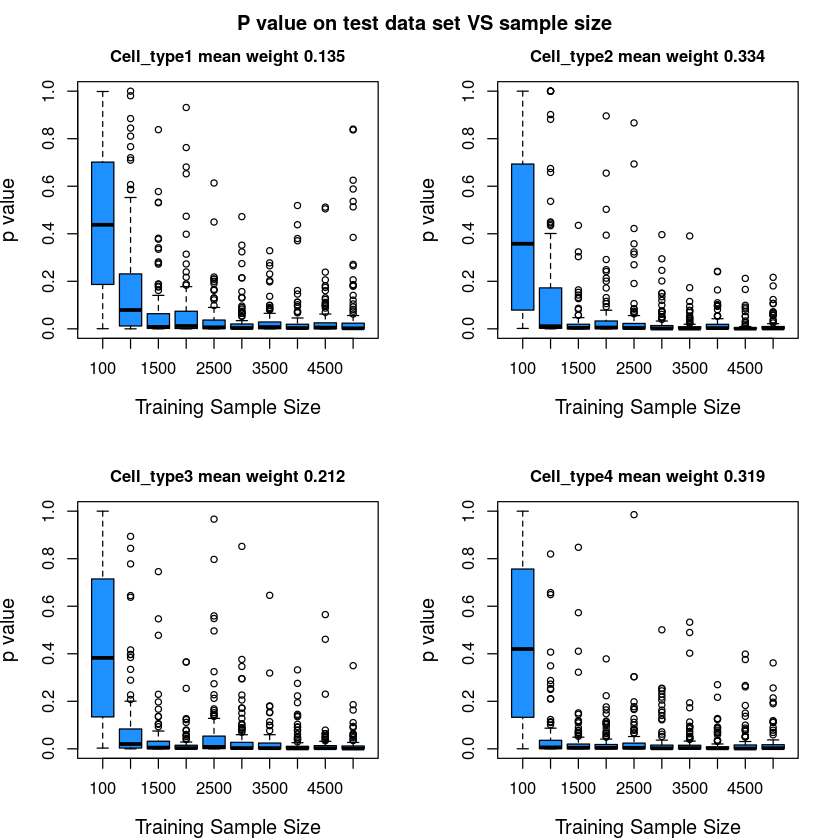

In [331]:
mean_weight = signif(apply(params$W,2,mean),digits=3)
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:params$K){
    temp = data.frame(t(p_value_matrix[,,i]))
    colnames(temp) = sample_size_arr
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    boxplot(temp,xlab='Training Sample Size',ylab='p value',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='dodgerblue')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
}
mtext("P value on test data set VS sample size",side=3,adj=3.5,cex=1,line=23.5,font=2)

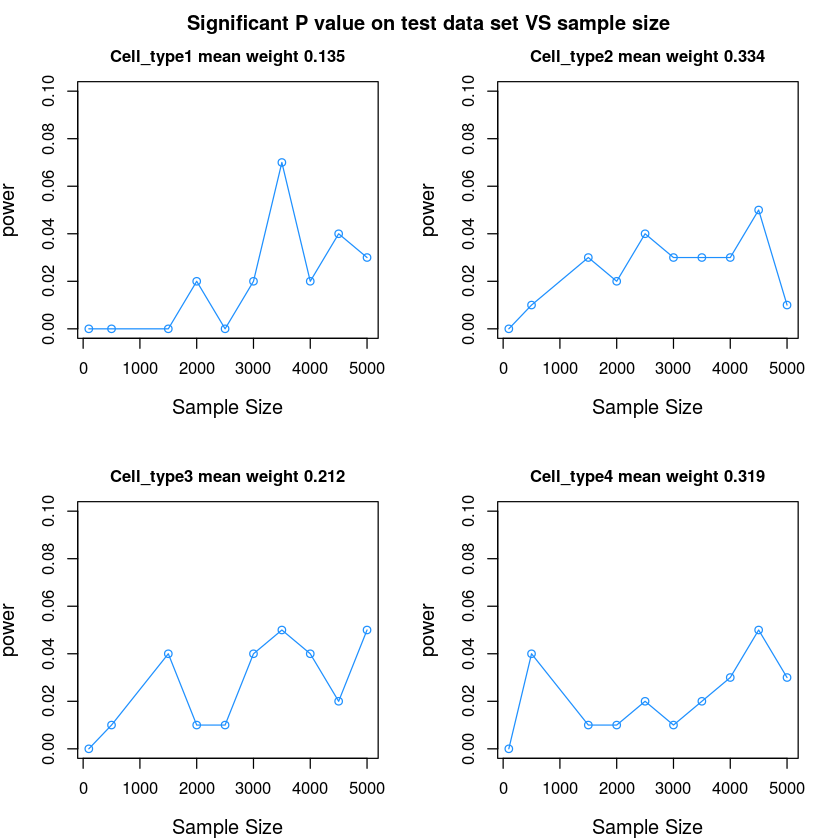

In [332]:
p_threshold = 0.05/10000/4
power_matrix = matrix(0,nrow=params$K,ncol=length(sample_size_arr))
for(cell_i in 1:params$K){
    power_matrix[cell_i,] = t(do.call(rbind,lapply(1:length(sample_size_arr),
                                                 function(x) sum(as.integer(p_value_matrix[x,,cell_i]<p_threshold)))))
}
power_matrix = power_matrix/params$M

mean_weight = signif(apply(params$W,2,mean),digits=3)
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:params$K){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(sample_size_arr,power_matrix[i,],xlab='Sample Size',
         ylab='power',cex.lab=1.2,ylim=c(0,0.1),yaxs='r',type='o',col='dodgerblue')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
}
mtext("Significant P value on test data set VS sample size",side=3,adj=1.7,cex=1,line=23.5,font=2)

### Sample Size Check
Correlation square is just r square, the proportion of variance explained

In [46]:
params = generate_params(cont_her=TRUE,seed=1)
data = lapply(1:params$M,function(x) one_gene(par=params,x))
              
# do TCA-TWAS for every gene, every sample size
prop = 0.7
sample_size_arr = c(1500,2000,2500,3000,3500,4000,4500,5000)
t_prop = floor(prop*params$N)
li = list()
for(g in 1:length(data)){
    print(paste('gene',g,sep='_'))
    for(sample_size in sample_size_arr){
        t_prop = floor(prop*sample_size)
        train_X = (data[[g]]$X)[1:t_prop,]
        test_X = data[[g]]$X[(t_prop+1):sample_size,]
        train_W = params$W[1:t_prop,]
        test_W = params$W[(t_prop+1):sample_size,]
        train_G = data[[g]]$G[,1:t_prop]
        test_G = data[[g]]$G[,(t_prop+1):sample_size]
        train_c1 = params$c1[1:t_prop,]
        test_c1 = params$c1[(t_prop+1):sample_size,]
        train_c2 = params$c2[1:t_prop,]
        test_c2 = params$c2[(t_prop+1):sample_size,]
        train_Z = data[[g]]$Z[1:t_prop,]
        test_Z = data[[g]]$Z[(t_prop+1):sample_size,]
        beta = data[[g]]$beta
        gamma_c1 = data[[g]]$gamma_c1
        gamma_c2 = data[[g]]$gamma_c2
        tca.mdl1 = tca(X=train_G,W=train_W,C1=cbind(train_X,train_c1),verbose=FALSE)
        tca.mdl2 = tca(X=train_G,W=train_W,C1=train_c1,verbose=FALSE)
        tca.mdl1.summary = summary_statistics(mdl=tca.mdl1,train_X=train_X,test_X=test_X,
                                              train_c1=train_c1,test_c1=test_c1,train_G=train_G,
                                              test_G=test_G,train_Z=train_Z,test_Z=test_Z,
                                              beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=1)
        tca.mdl2.summary = summary_statistics(mdl=tca.mdl2,train_X=train_X,test_X=test_X,
                                              train_c1=train_c1,test_c1=test_c1,train_G=train_G,
                                              test_G=test_G,train_Z=train_Z,test_Z=test_Z,
                                              beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=2)
        li[[paste(g,'.',sample_size,sep='')]] = list('s1'=tca.mdl1.summary,'s2'=tca.mdl2.summary)
    }
}

[1] "gene_1"


Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):


[1] "gene_2"


Warning message in cor(t(train_G), G_hat_train_lasso):
“the standard deviation is zero”Warning message in cor(t(test_G), G_hat_test_lasso):
“the standard deviation is zero”

[1] "gene_3"
[1] "gene_4"


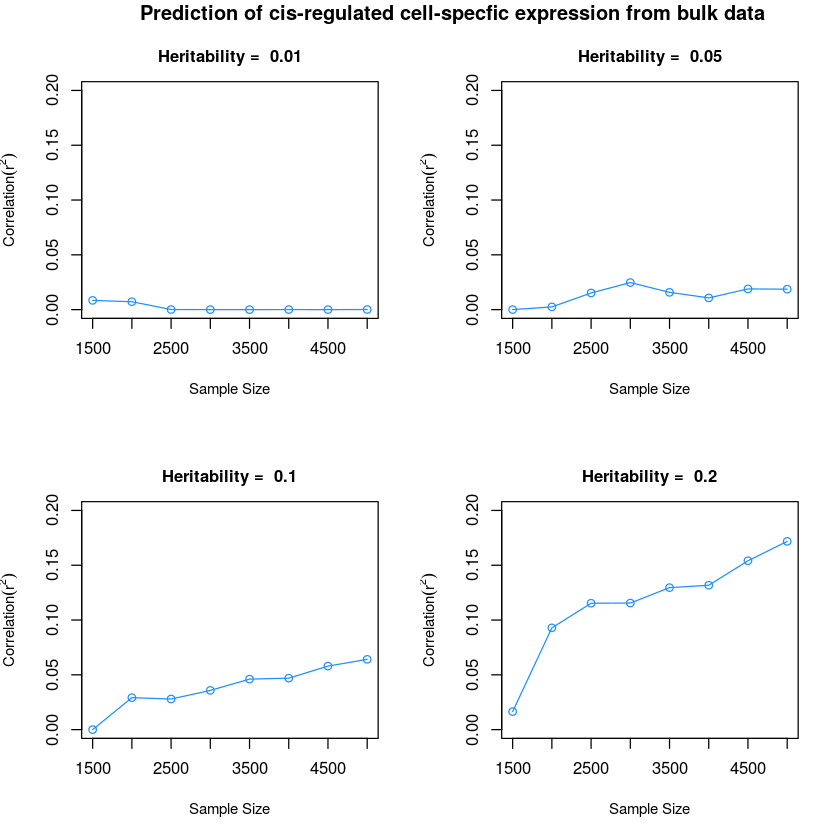

In [116]:
par(mfrow=c(2,2))
opts=paste('Heritability = ',params$her[1,])
for(i in 1:length(data)){
    cor_sample_size = do.call(rbind,lapply(1:length(sample_size_arr),
                                                    function(x) li[[paste(i,'.',sample_size_arr[x],sep='')]]$s1$cor_lasso_real_test))
    plot(sample_size_arr,cor_sample_size[,1]^2,xlab='Sample Size',
         ylab=parse(text='Correlation (r^2)'),cex.lab=0.9,ylim=c(0,0.2),yaxs='r',type='o',col='dodgerblue')
    title(main=opts[i],font.main=2,cex.main=1,line=1,cex.lab=1)
    #lines(sample_size_arr,cor_sample_size[,2]^2,col='black',type='o')
    #lines(sample_size_arr,cor_sample_size[,3]^2,col='purple',type='o')
    #lines(sample_size_arr,cor_sample_size[,4]^2,col='blue',type='o')
}
mtext("Prediction of cis-regulated cell-specfic expression from bulk data",side=3,adj=1.1,cex=1,line=24,font=2)
# par(mfrow=c(2,1),mar=c(0,0,0,0))
# plot(1,type='n',axes=FALSE,xlab='',ylab='')
# legend(x='top',inset=0,legend=c('cell1','cell2','cell3','cell4'),
#        col=c('orange','black','purple','blue'),lwd=2,cex=0.7,horiz=TRUE)

### Bulk Level Heritability Check/Analysis

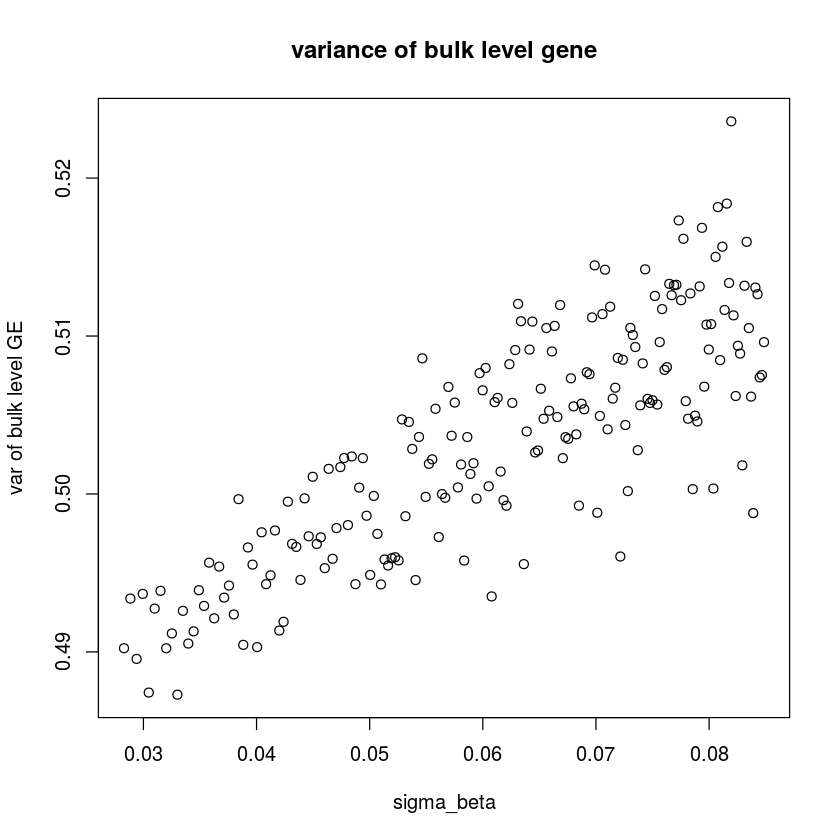

In [159]:
params = generate_params(cont_her=TRUE,seed=1)
data = lapply(1:params$M,function(x) one_gene(par=params,x))
mean_G2 = do.call(rbind,lapply(1:params$M,function(x) mean(unlist(data[[x]]$G))))
mean_G1 = do.call(rbind,lapply(1:params$M,function(x) mean((data[[x]]$G)^2)))
var_g_real = do.call(rbind,lapply(1:params$M,function(x) var(unlist(data[[x]]$G))))
sum_expec_weight_sq = sum(apply(params$W^2,2,mean))
var_g_theo = (params$sigma_g^2+sum_expec_weight_sq)
# As variance of beta goes up, so does bulk level variance
sigma_beta_ = sqrt(params$her[1,]/params$D/params$pslab[,1])
plot(sigma_beta_,mean_G1,xlab='sigma_beta',ylab='var of bulk level GE')
title('variance of bulk level gene')

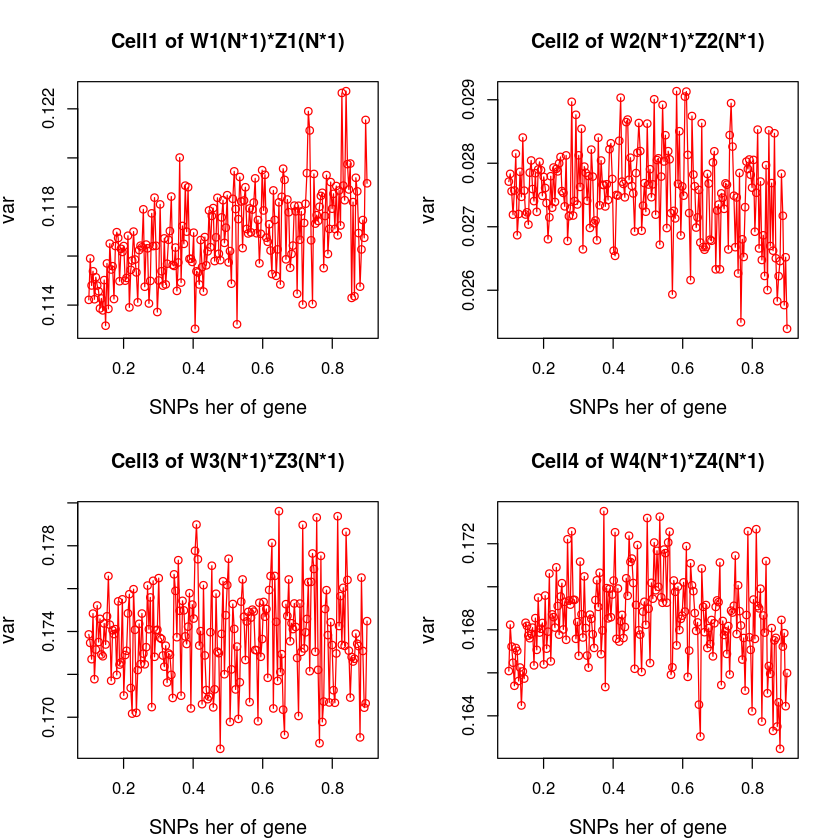

In [145]:
# The W*Z terms in the variance.
wz1 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,1]*data[[x]]$Z[,1])))
wz2 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,2]*data[[x]]$Z[,2])))
wz3 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,3]*data[[x]]$Z[,3])))
wz4 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,4]*data[[x]]$Z[,4])))
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
plot(params$her[1,],wz1,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell1 of W1(N*1)*Z1(N*1)')
plot(params$her[1,],wz2,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell2 of W2(N*1)*Z2(N*1)')
plot(params$her[1,],wz3,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell3 of W3(N*1)*Z3(N*1)')
plot(params$her[1,],wz4,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell4 of W4(N*1)*Z4(N*1)')

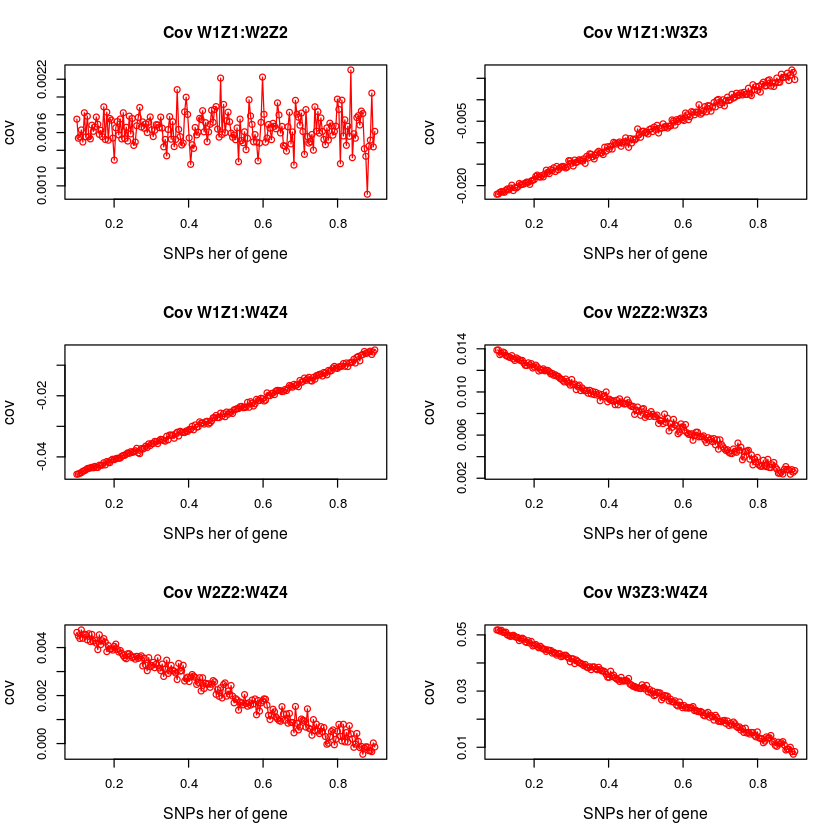

In [172]:
# The Cov[W1(*)Z1],W2(*)Z2] terms in the variance.
par(mfrow=c(3,2))
cov = matrix(0,nrow=6,ncol=params$M)
ticker = 1
for(i in 1:3){
    for(j in (i+1):4){
        cov[ticker,] = do.call(rbind,
                      lapply(1:params$M,function(x) cov(params$W[,i]*data[[x]]$Z[,i],
                                                   params$W[,j]*data[[x]]$Z[,j])))
        plot(params$her[1,],cov[ticker,],xlab='SNPs her of gene',
            ylab='cov',cex.lab=1.2,yaxs='r',type='o',col='red')
        title(main=paste('Cov W',i,'Z',i,':W',j,'Z',j,sep=''))
        ticker = ticker+1
    }
}

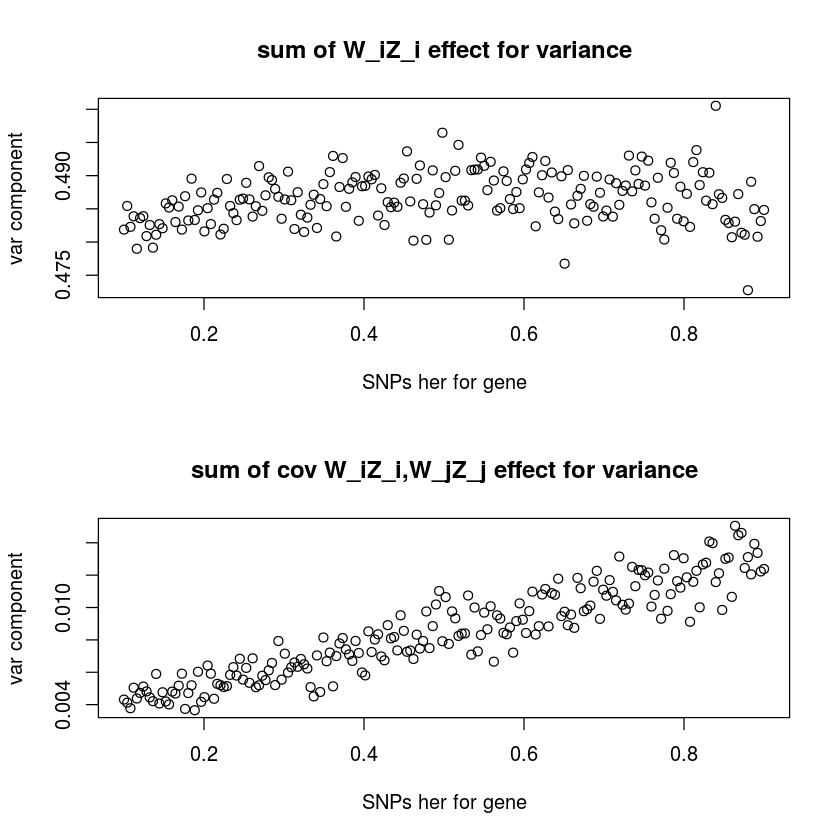

In [187]:
sum_of_ind_effect = apply(t(cbind(wz1,wz2,wz3,wz4)),2,sum)
sum_of_cov_effect = apply(cov,2,sum)

par(mfrow=c(2,1))
plot(params$her[1,],sum_of_ind_effect,xlab='SNPs her for gene',ylab='var component')
title(main='sum of W_iZ_i effect for variance')
plot(params$her[1,],sum_of_cov_effect,xlab='SNPs her for gene',ylab='var component')
title(main='sum of cov W_iZ_i,W_jZ_j effect for variance')

In [238]:
# What cause the covariance to change with beta sigma?
# It turned out that it is not the second term in the covariance term
# E[w1(*)Xbeta1]' *E[w3(*)Xbeta3] is a number. But 200 genes.
cov13_21=t(do.call(rbind,lapply(1:params$M,function(x) mean(params$W[,1]*data[[x]]$Z[,1]))))
cov13_22=t(do.call(rbind,lapply(1:params$M,function(x) mean(params$W[,3]*data[[x]]$Z[,3]))))
cov13_2 = cov13_21*cov13_22
# print out cov13_2 for this to check

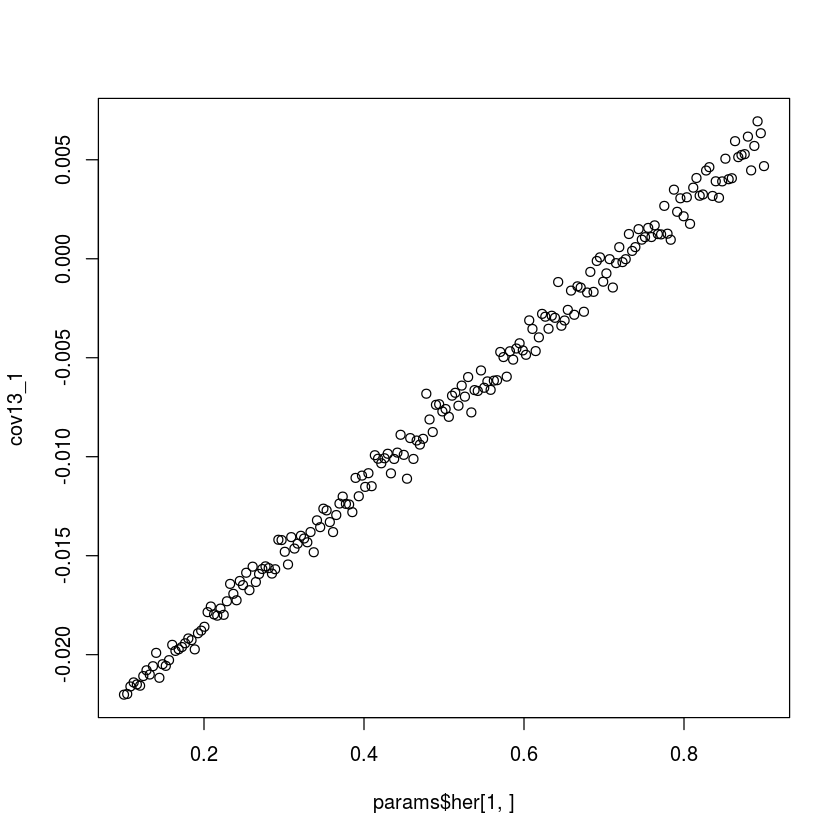

In [276]:
# It turned out that E[(W1(*)Z1)'*(W3(*)Z3)]
cov13_1 = lapply(1:200,function(x) 
    mean((params$W[,1]*data[[x]]$Z[,1])*(params$W[,3]*data[[x]]$Z[,3])))
plot(params$her[1,],cov13_1)

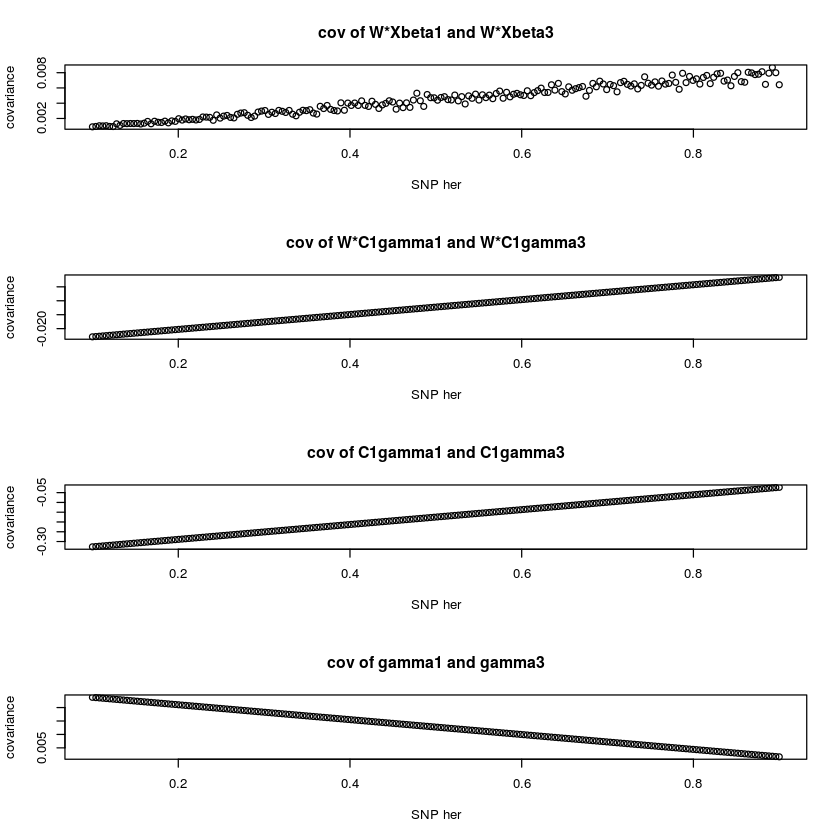

In [288]:
cov13_xbeta = lapply(1:200,function(x) 
    mean((params$W[,1]*(data[[x]]$X %*% data[[x]]$beta[1,]))*
         (params$W[,3]*(data[[x]]$X %*% data[[x]]$beta[3,]))))
#plot(params$her[1,],cov13_xbeta)
# how come it is the cross entropy of the c1 gamma that is contributing?
cov13_c1gamma = lapply(1:200,function(x) 
    mean((params$W[,1]*(params$c1 %*% data[[x]]$gamma_c1[,1]))*
         (params$W[,3]*(params$c1 %*% data[[x]]$gamma_c1[,3]))))
#plot(params$her[1,],cov13_c1gamma)
# This could be further explained by the covariance of c1 gamma_c1
cov13_c1gamma_pure = lapply(1:200,function(x) 
    mean(((params$c1 %*% data[[x]]$gamma_c1[,1]))*
         ((params$c1 %*% data[[x]]$gamma_c1[,3]))))
#plot(params$her[1,],cov13_c1gamma_pure)
                            
par(mfrow=c(4,1))
plot(params$her[1,],cov13_xbeta,xlab='SNP her',ylab='covariance')
title(main='cov of W*Xbeta1 and W*Xbeta3')
plot(params$her[1,],cov13_c1gamma,xlab='SNP her',ylab='covariance')
title(main='cov of W*C1gamma1 and W*C1gamma3')
plot(params$her[1,],cov13_c1gamma_pure,xlab='SNP her',ylab='covariance')
title(main='cov of C1gamma1 and C1gamma3')
gamma_cor = do.call(rbind,lapply(1:200,function(x) cov(data[[x]]$gamma_c1[,1],data[[x]]$gamma_c1[,3])))
plot(params$her[1,],gamma_cor,xlab='SNP her',ylab='covariance')
title(main='cov of gamma1 and gamma3')

### Plotting Begins for Heritibility Check

In [161]:
herr_arr=c(1:40)/100
params = generate_params(cell_her=TRUE,gene_cor=FALSE,bulk_her=FALSE,
                         seed=1,N=5000,M=10,
                         D=250,pslab=0.5,her=0.05,
                         her_bulk=0.6,herr_arr=herr_arr)
data = lapply(1:params$M,function(x) one_gene(par=params,x))

In [165]:
# do TCA-TWAS for every gene
prop = 0.7
t_prop = floor(prop*params$N)
li = list()
for(g in 1:length(data)){
    print(paste('gene',g,sep='_'))
    train_X = (data[[g]]$X)[1:t_prop,]
    test_X = data[[g]]$X[(t_prop+1):params$N,]
    train_W = params$W[1:t_prop,]
    test_W = params$W[(t_prop+1):params$N,]
    train_G = data[[g]]$G[,1:t_prop]
    test_G = data[[g]]$G[,(t_prop+1):params$N]
    train_c1 = params$c1[1:t_prop,]
    test_c1 = params$c1[(t_prop+1):params$N,]
    train_c2 = params$c2[1:t_prop,]
    test_c2 = params$c2[(t_prop+1):params$N,]
    train_Z = data[[g]]$Z[1:t_prop,]
    test_Z = data[[g]]$Z[(t_prop+1):params$N,]
    beta = data[[g]]$beta
    gamma_c1 = data[[g]]$gamma_c1
    gamma_c2 = data[[g]]$gamma_c2
    tca.mdl1 = tca(X=train_G,W=train_W,C1=cbind(train_X,train_c1),verbose=FALSE)
    #tca.mdl2 = tca(X=train_G,W=train_W,C1=train_c1,verbose=FALSE)
    tca.mdl1.summary = summary_statistics(mdl=tca.mdl1,train_X=train_X,test_X=test_X,
                                          train_c1=train_c1,test_c1=test_c1,train_G=train_G,
                                          test_G=test_G,train_Z=train_Z,test_Z=test_Z,
                                          beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=1)
    #tca.mdl2.summary = summary_statistics(mdl=tca.mdl2,train_X=train_X,test_X=test_X,
    #                                      train_c1=train_c1,test_c1=test_c1,train_G=train_G,
    #                                      test_G=test_G,train_Z=train_Z,test_Z=test_Z,
    #                                      beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=2)
    li[[g]] = list('s1'=tca.mdl1.summary)#,'s2'=tca.mdl2.summary)
}

[1] "gene_1"
[1] "gene_2"
[1] "gene_3"
[1] "gene_4"
[1] "gene_5"
[1] "gene_6"
[1] "gene_7"
[1] "gene_8"
[1] "gene_9"
[1] "gene_10"
[1] "gene_11"
[1] "gene_12"
[1] "gene_13"
[1] "gene_14"
[1] "gene_15"
[1] "gene_16"
[1] "gene_17"
[1] "gene_18"
[1] "gene_19"
[1] "gene_20"
[1] "gene_21"
[1] "gene_22"
[1] "gene_23"
[1] "gene_24"
[1] "gene_25"
[1] "gene_26"
[1] "gene_27"
[1] "gene_28"
[1] "gene_29"
[1] "gene_30"
[1] "gene_31"
[1] "gene_32"
[1] "gene_33"
[1] "gene_34"
[1] "gene_35"
[1] "gene_36"
[1] "gene_37"
[1] "gene_38"
[1] "gene_39"
[1] "gene_40"


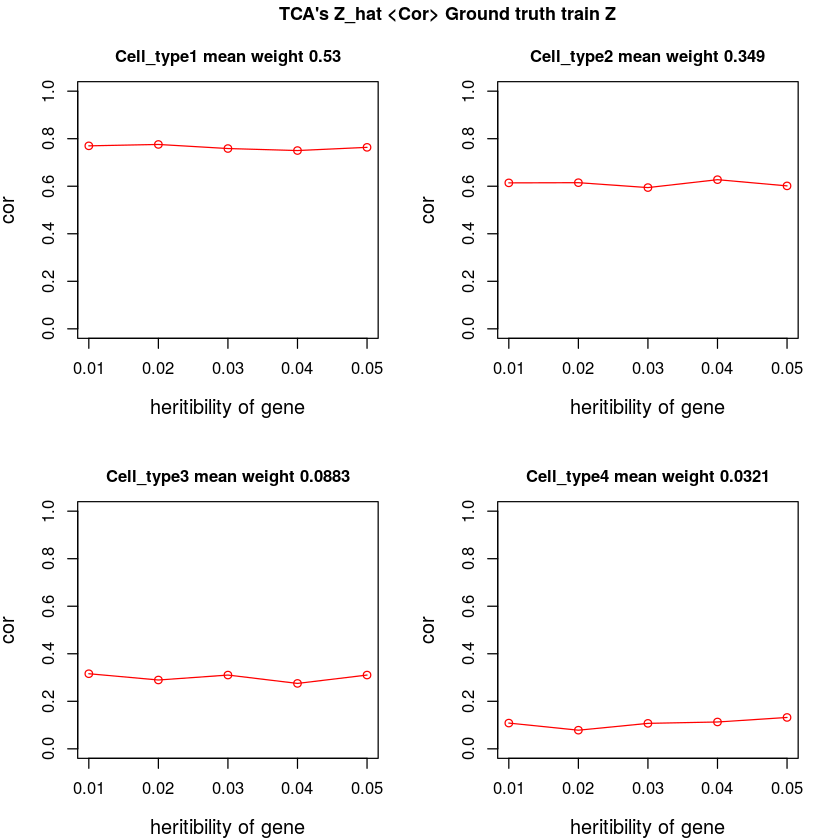

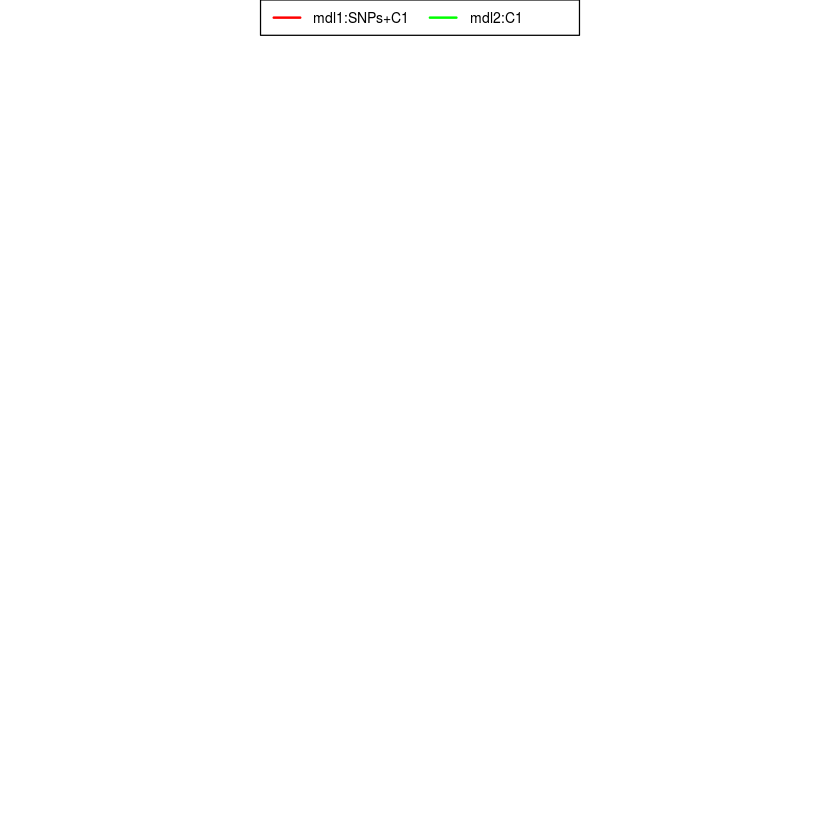

In [167]:
mean_weight = signif(apply(params$W,2,mean),digits=3)
Z_hat_cor_tca1 = do.call(rbind,lapply(1:5,function(x) li[[x]]$s1$Z_hat_cor_tca))
#Z_hat_cor_tca2 = do.call(rbind,lapply(1:5,function(x) li[[x]]$s2$Z_hat_cor_tca))                                      

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,1:5],Z_hat_cor_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    #lines(params$her[i,1:5],Z_hat_cor_tca2[,i],col='green',type='o')
    
}
mtext("TCA's Z_hat <Cor> Ground truth train Z",side=3,adj=6,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1:SNPs+C1','mdl2:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

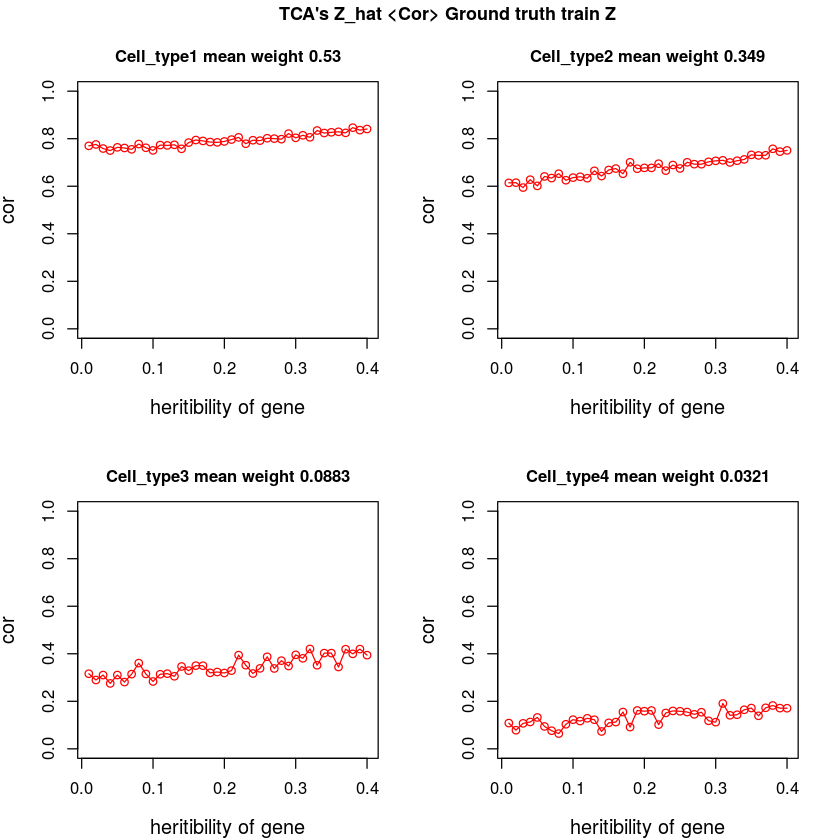

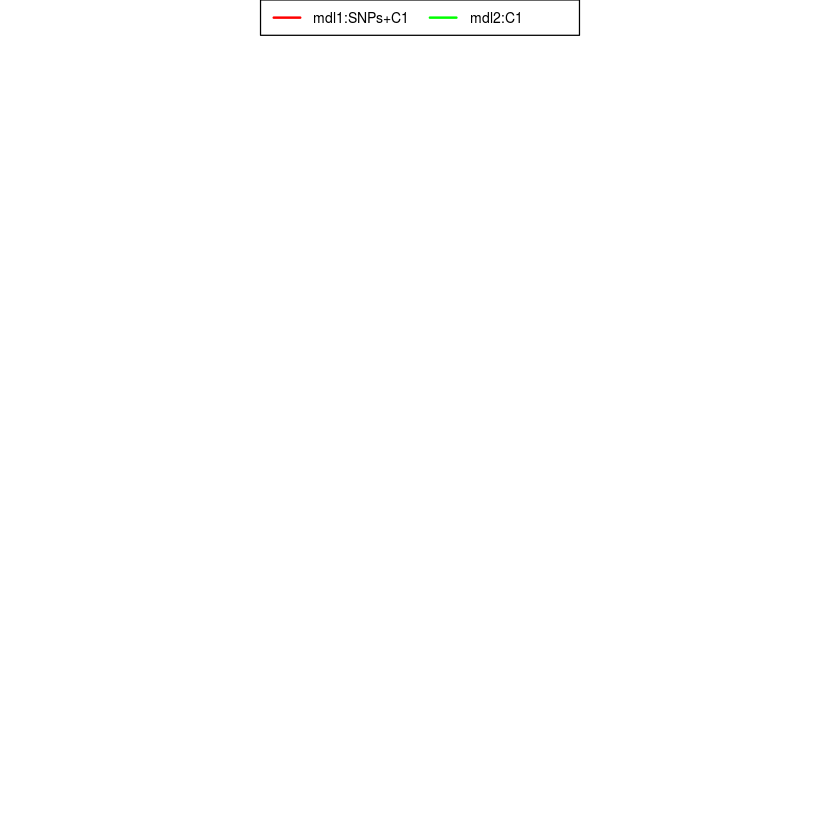

In [168]:
mean_weight = signif(apply(params$W,2,mean),digits=3)
Z_hat_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$Z_hat_cor_tca))
#Z_hat_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$Z_hat_cor_tca))                                      

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],Z_hat_cor_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    #lines(params$her[i,],Z_hat_cor_tca2[,i],col='green',type='o')
    
}
mtext("TCA's Z_hat <Cor> Ground truth train Z",side=3,adj=6,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1:SNPs+C1','mdl2:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

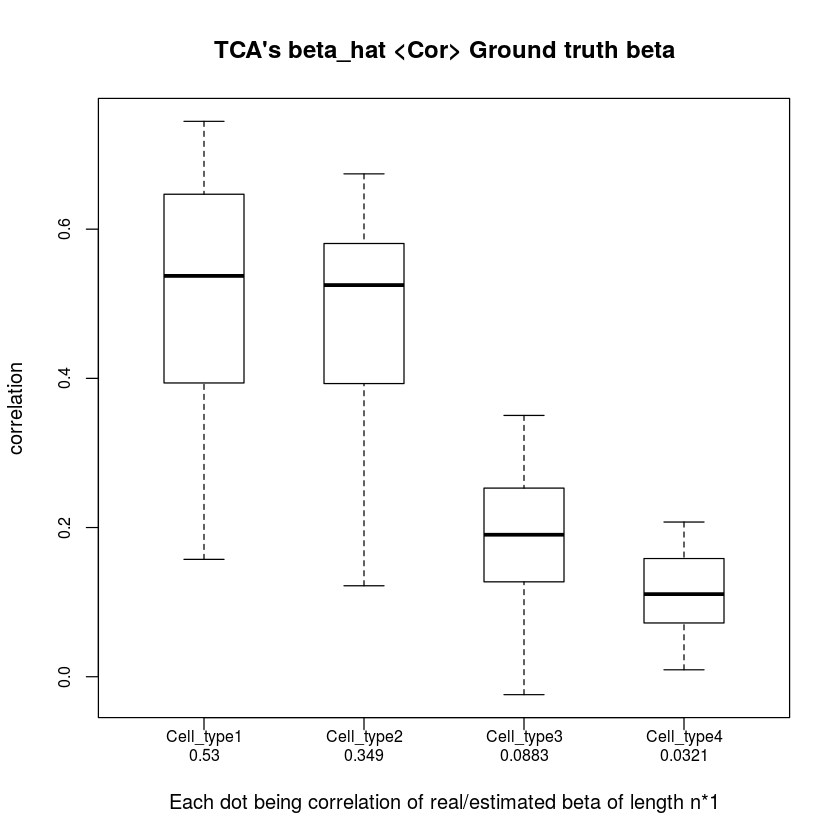

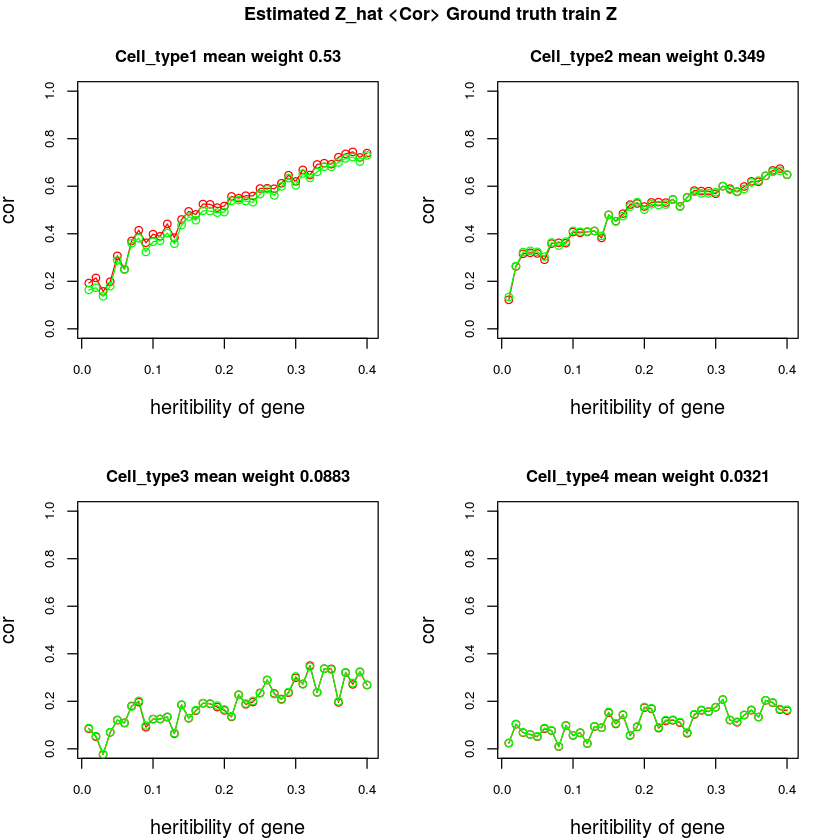

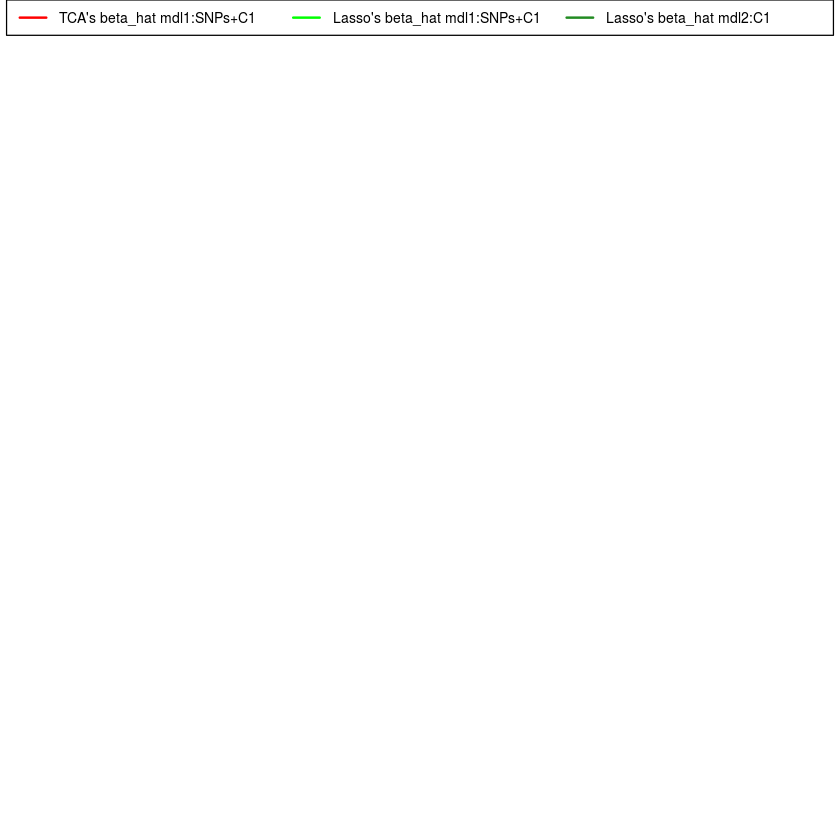

In [176]:
beta_hat_cor_tca = do.call(rbind,lapply(1:length(data),function(x) unlist(li[[x]]$s1$beta_hat_cor_tca)))
colnames(beta_hat_cor_tca) = paste(params$cell_name,mean_weight,sep='\n')
cor_beta_lasso_real1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$cor_beta_lasso_real))
cor_beta_lasso_real2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$cor_beta_lasso_real))
#colnames(cor_beta_lasso_real1) = paste(params$cell_name,mean_weight,sep='\n')
#colnames(cor_beta_lasso_real2) = paste(params$cell_name,mean_weight,sep='\n')
# Cell type weight and correlation
par(cex.axis=.8)
boxplot(beta_hat_cor_tca,ylab='correlation',
        xlab='Each dot being correlation of real/estimated beta of length n*1',
        boxwex=0.5,main="TCA's beta_hat <Cor> Ground truth beta")
# Heritibility and correlation
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],beta_hat_cor_tca[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    lines(params$her[i,],cor_beta_lasso_real1[,i],type='o',col='green')
    lines(params$her[i,],cor_beta_lasso_real2[,i],type='o',col='forestgreen')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
}
mtext("Estimated Z_hat <Cor> Ground truth train Z",side=3,adj=3.5,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c("TCA's beta_hat mdl1:SNPs+C1","Lasso's beta_hat mdl1:SNPs+C1","Lasso's beta_hat mdl2:C1"),
       col=c('red','green','forestgreen'),lwd=2,cex=0.7,horiz=TRUE)

In [177]:
gamma_hat_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$gamma_hat_cor_tca))
gamma_hat_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$gamma_hat_cor_tca))
gamma_cor = cbind(gamma_hat_cor_tca1,gamma_hat_cor_tca2)
colnames(gamma_cor) = c('mdl1:SNPs+C1','mdl2:C1')
boxplot(gamma_cor,main="TCA's gamma_hat <Cor> Ground truth gamma_hat",
        ylab='cor',boxwex=0.5,
        xlab='correlation of effect size of smoking/age/gender')

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [2] not equal to array extent


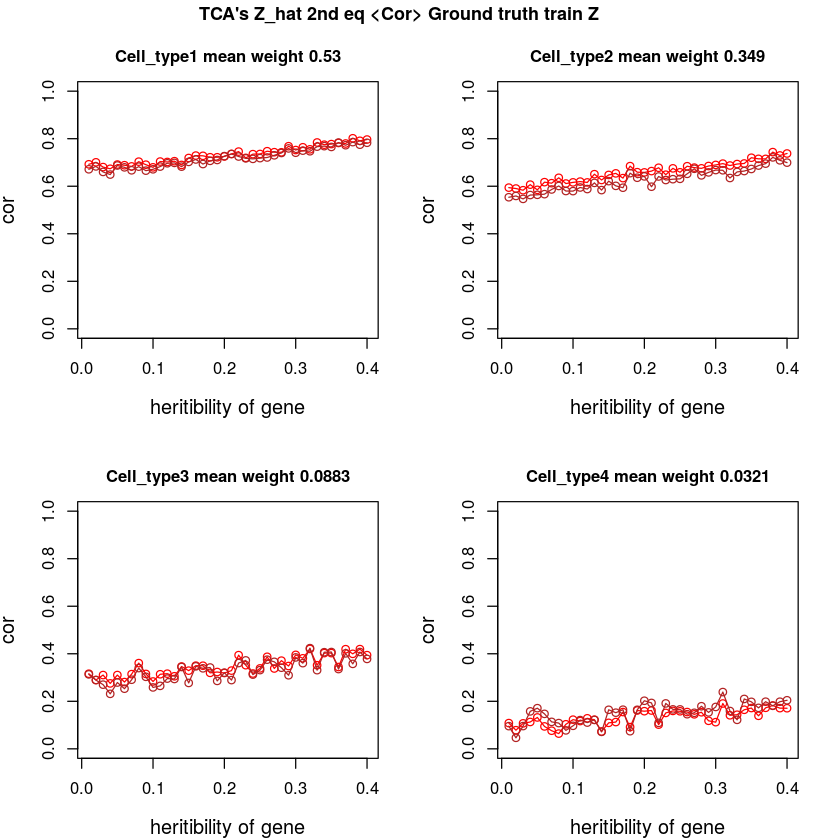

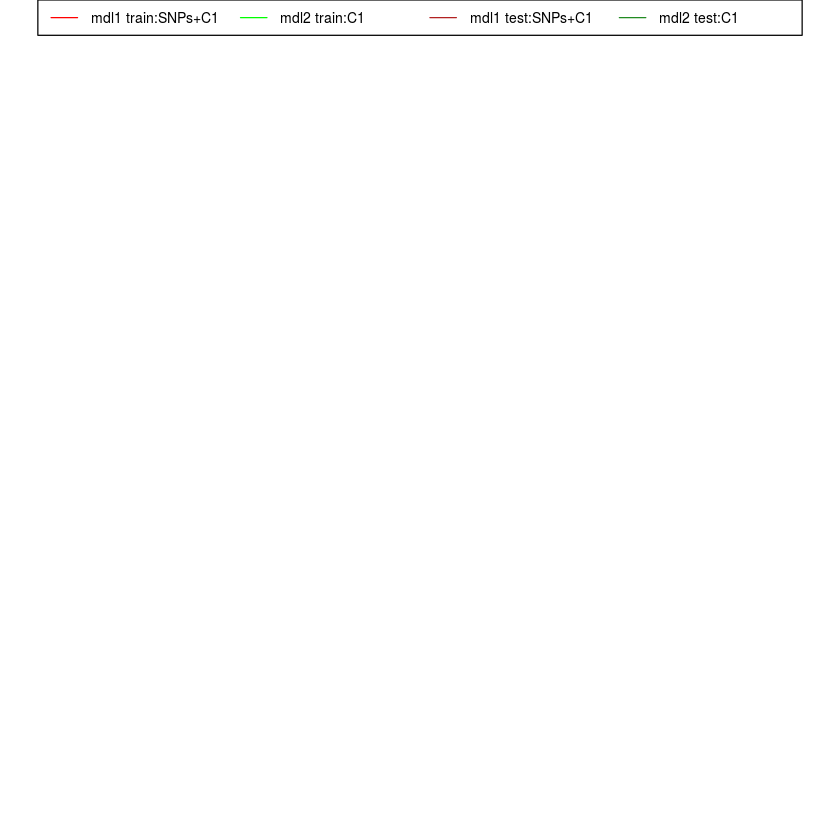

In [178]:
Z_hat_train_seq_eq_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$Z_hat_train_second_eq_cor_tca))
Z_hat_train_seq_eq_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$Z_hat_train_second_eq_cor_tca))
Z_hat_test_seq_eq_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$Z_hat_test_second_eq_cor_tca))
Z_hat_test_seq_eq_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$Z_hat_test_second_eq_cor_tca))

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:params$K){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],Z_hat_train_seq_eq_cor_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],Z_hat_train_seq_eq_cor_tca2[,i],col='green',type='o')
    lines(params$her[i,],Z_hat_test_seq_eq_cor_tca1[,i],col='firebrick',type='o')
    lines(params$her[i,],Z_hat_test_seq_eq_cor_tca2[,i],col='forestgreen',type='o')
}
mtext("TCA's Z_hat 2nd eq <Cor> Ground truth train Z",side=3,adj=3,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1 train:SNPs+C1','mdl2 train:C1','mdl1 test:SNPs+C1','mdl2 test:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.7,horiz=TRUE)

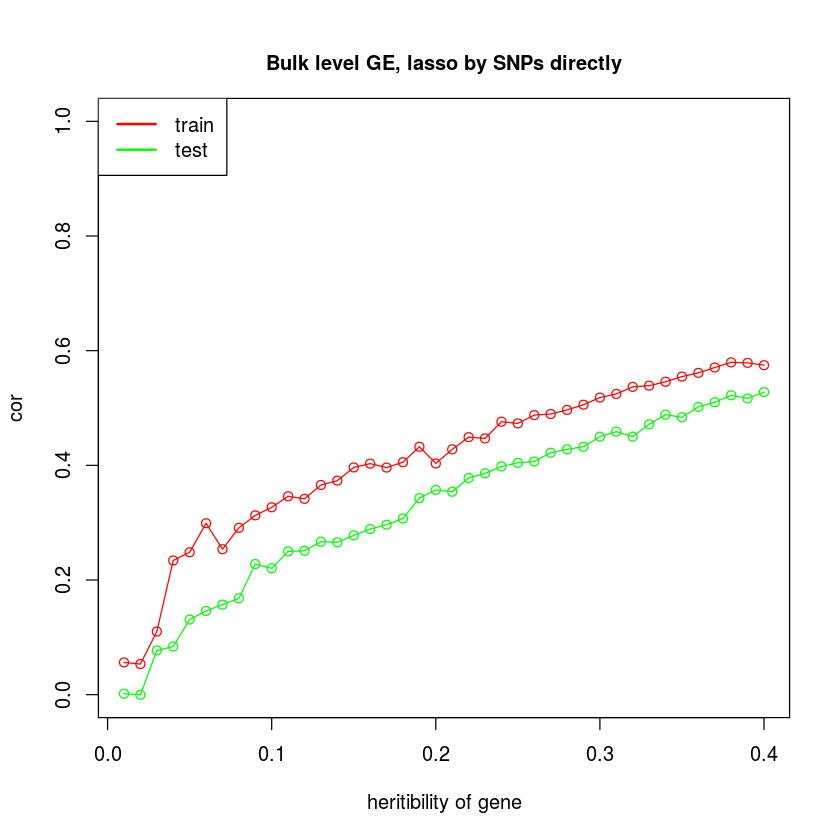

In [179]:
G_hat_train_cor_bulk = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$G_hat_train_cor_bulk))
G_hat_test_cor_bulk = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$G_hat_test_cor_bulk))
plot(params$her[1,],G_hat_train_cor_bulk,type='o',col='red',xlab='heritibility of gene',ylab='cor',ylim=c(0,1))
mtext("Bulk level GE, lasso by SNPs directly",font=2,line=1)
lines(params$her[1,],G_hat_test_cor_bulk,col='green',type='o')
legend(x='topleft',inset=0,legend=c('train','test'),
       col=c('red','green'),lwd=2,cex=1,horiz=FALSE)

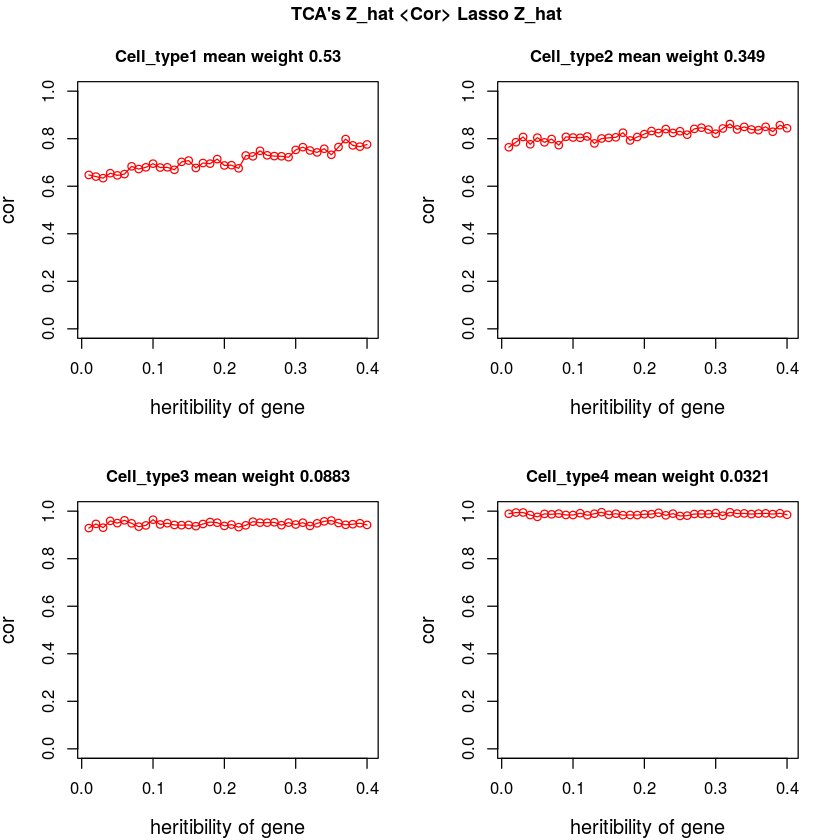

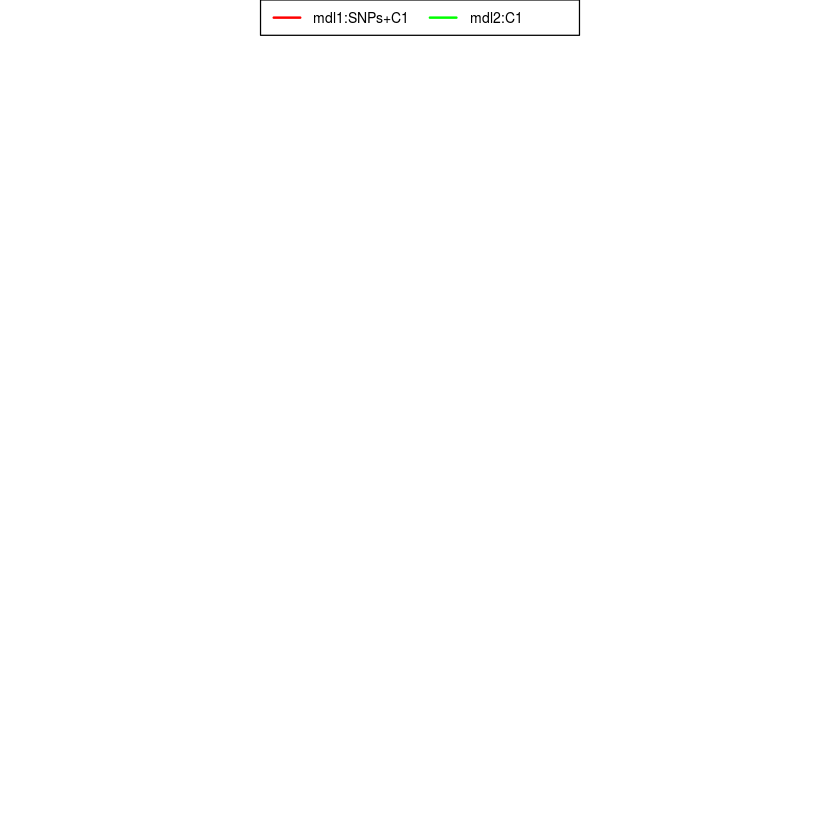

In [180]:
cor_lasso_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$cor_lasso_tca))
cor_lasso_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$cor_lasso_tca))
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],cor_lasso_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],cor_lasso_tca2[,i],col='green',type='o')
    
}
mtext("TCA's Z_hat <Cor> Lasso Z_hat",side=3,adj=-7,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1:SNPs+C1','mdl2:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

Saving 6.67 x 6.67 in image


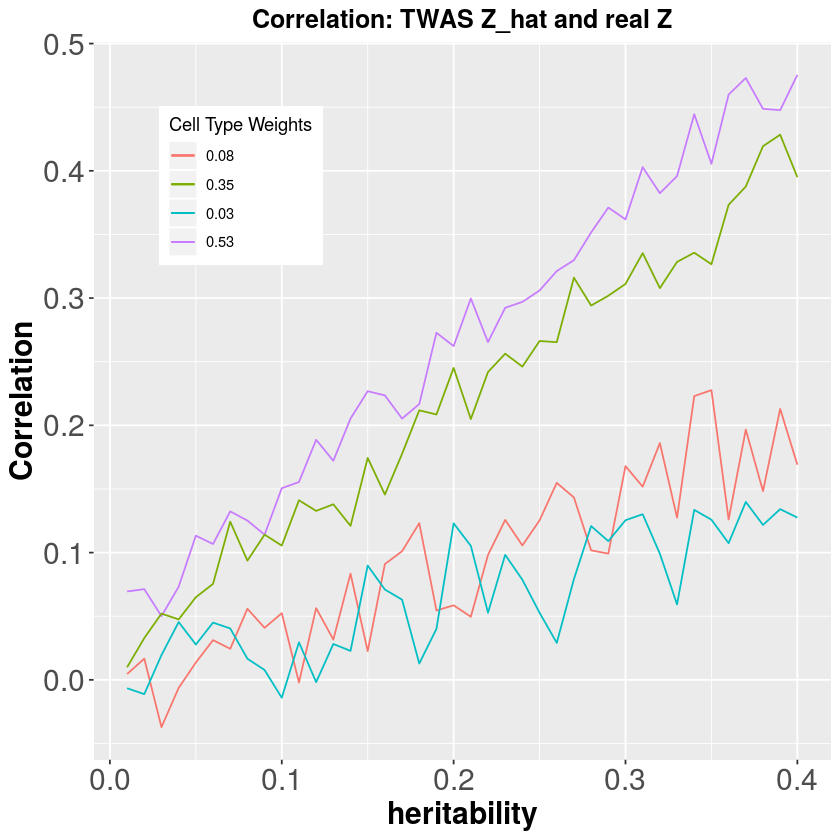

In [259]:
zhat_cor = data.frame(heritability=params$her[i,],cor=cor_lasso_real_test1)
colnames(zhat_cor) = c('heritability','cor_celltype1','cor_celltype2','cor_celltype3','cor_celltype4')
ggplot(zhat_cor,aes(heritability))+geom_line(
    aes(y=cor_celltype1,color=hue_pal()(4)[1]))+geom_line(
    aes(y=cor_celltype2,color=hue_pal()(4)[2]))+geom_line(
    aes(y=cor_celltype3,color=hue_pal()(4)[3]))+geom_line(
    aes(y=cor_celltype4,color=hue_pal()(4)[4]))+ggtitle(
    "Correlation: TWAS Z_hat and real Z")+theme(
    axis.text=element_text(size=18),
    axis.title=element_text(size=18,face="bold"),
    plot.title = element_text(size=15,face="bold",hjust=0.5),
    legend.position = c(0.2, 0.8))+labs(
    y="Correlation")+scale_color_discrete(name="Cell Type Weights",labels=c(0.08,0.35,0.03,0.53))
ggsave("/home/elessar/Documents/activities/hackathon/urop/UCLA/csst/tca-twas/pipeline/plot/cor_twas_zhat_real_z.png",
       plot = last_plot(),dpi = 300, limitsize = TRUE)

In [182]:
par(mar=c(0,0,0,0),cex.axis=.7)
par(mfrow=c(2,2),mar=c(3.8, 3.7, 4, 2))
boxplot(cor_lasso_real_train1,ylab='cor',
        xlab='mdl1 train:SNPs+C1',boxwex=0.7,ylim=c(0,1))
boxplot(cor_lasso_real_train2,ylab='cor',
        xlab='mdl2 train:C1',boxwex=0.7,ylim=c(0,1))
boxplot(cor_lasso_real_test1,ylab='cor',
        xlab='mdl1 test:SNPs+C1',ylim=c(0,1),boxwex=0.7)
boxplot(cor_lasso_real_test2,ylab='cor',
        xlab='mdl2 test:C1',boxwex=0.7,ylim=c(0,1))
mtext("Lasso Z_hat <Cor> Ground Truth Z",side=3,adj=8,cex=1,line=23,font=2)

ERROR: Error in boxplot(cor_lasso_real_train2, ylab = "cor", xlab = "mdl2 train:C1", : object 'cor_lasso_real_train2' not found


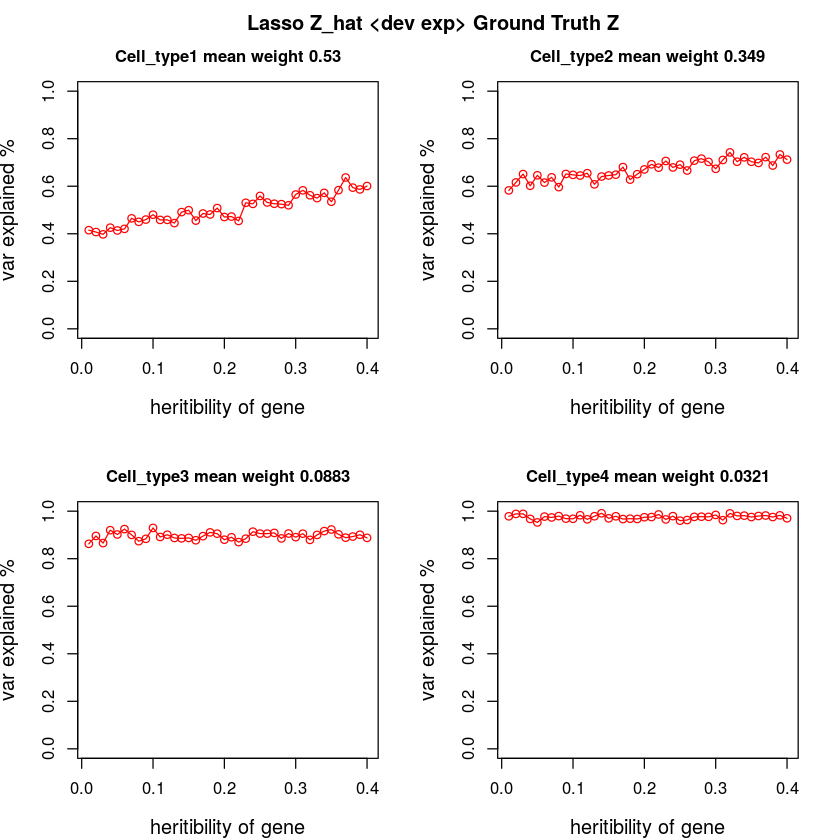

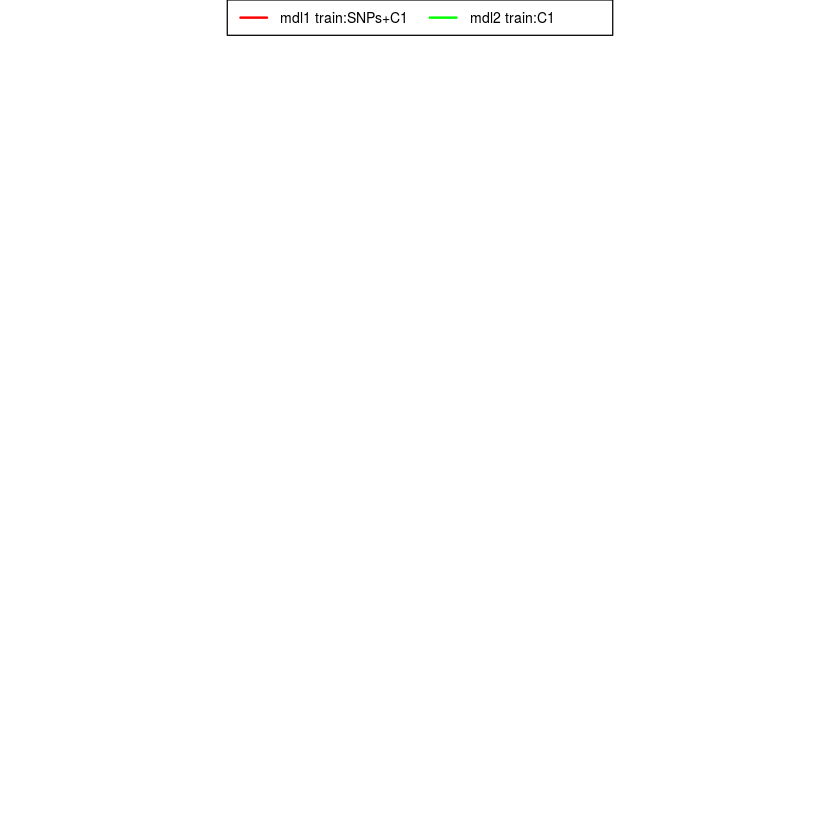

In [254]:
lasso_dev_rat1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$dev_rat))
#lasso_dev_rat2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$dev_rat))
colnames(lasso_dev_rat1) = paste(params$cell_name,'\n',mean_weight)
#colnames(lasso_dev_rat2) = paste(params$cell_name,'\n',mean_weight)
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:params$K){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],lasso_dev_rat1[,i],xlab='heritibility of gene',
         ylab='var explained %',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    #lines(params$her[i,],lasso_dev_rat2[,i],col='green',type='o')
}
mtext("Lasso Z_hat <dev exp> Ground Truth Z",side=3,adj=3.5,cex=1,line=23.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1 train:SNPs+C1','mdl2 train:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

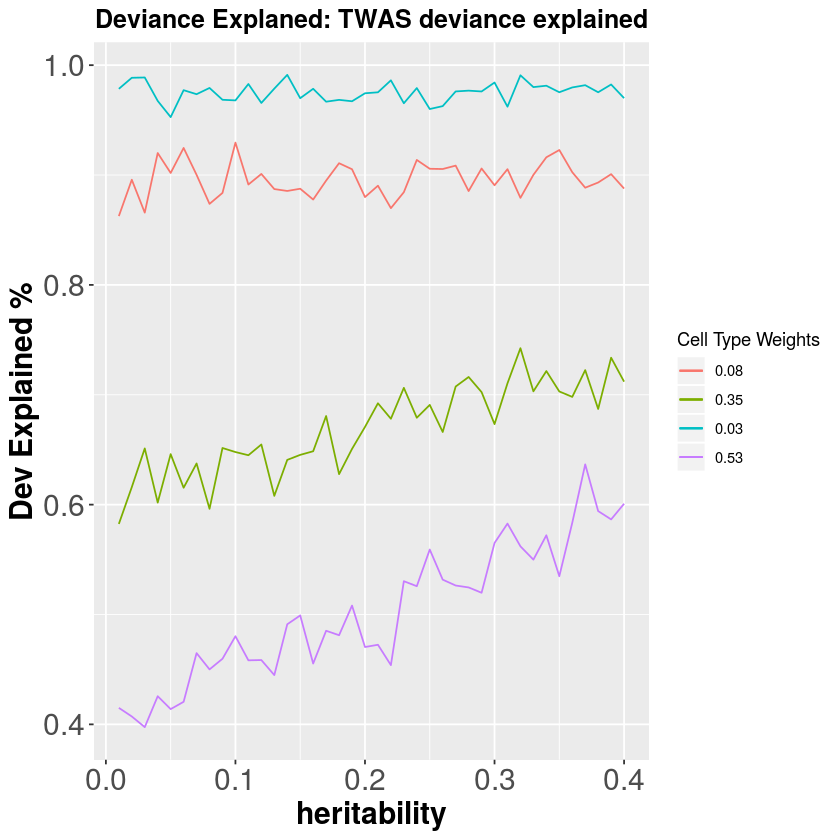

In [183]:
lasso_dev_rat1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$dev_rat))
colnames(lasso_dev_rat1) = paste(params$cell_name,'\n',mean_weight)                                      
zhat_dev_exp = data.frame(heritability=params$her[i,],lasso_dev_rat1)
colnames(zhat_dev_exp) = c('heritability','dev_celltype1','dev_celltype2','dev_celltype3','dev_celltype4')
ggplot(zhat_dev_exp,aes(heritability))+geom_line(
    aes(y=dev_celltype1,color=hue_pal()(4)[1]))+geom_line(
    aes(y=dev_celltype2,color=hue_pal()(4)[2]))+geom_line(
    aes(y=dev_celltype3,color=hue_pal()(4)[3]))+geom_line(
    aes(y=dev_celltype4,color=hue_pal()(4)[4]))+ggtitle(
    "Deviance Explaned: TWAS deviance explained")+theme(
    axis.text=element_text(size=18),
    axis.title=element_text(size=18,face="bold"),
    plot.title = element_text(size=15,face="bold",hjust=0.5))+labs(
    y="Dev Explained %")+scale_color_discrete(name="Cell Type Weights",labels=c(0.08,0.35,0.03,0.53))
# ggsave("/home/elessar/Documents/activities/hackathon/urop/UCLA/csst/tca-twas/pipeline/plot/twas_zhat_dev_exp.png",
#        plot = last_plot(),dpi = 300, limitsize = TRUE)

In [253]:
beta_precision_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$precision_lasso)),nrow=params$K)
#beta_precision_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$precision_lasso)),nrow=params$K)
beta_recall_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$recall_lasso)),nrow=params$K)
#beta_recall_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$recall_lasso)),nrow=params$K)
prec_rec_frame = lapply(1:params$K,function(x) t(rbind(beta_precision_lasso1[x,],beta_recall_lasso1[x,])))#,beta_recall_lasso1[x,],beta_recall_lasso2[x,])))

colnames(prec_rec_frame[[1]]) = c('precision','recall')
opts=paste(params$cell_name,' W:',mean_weight)
png('/home/elessar/Documents/activities/hackathon/urop/UCLA/csst/tca-twas/pipeline/plot/precrecall.png', units='px',width=1200, height=1200, res=150)
boxplot(prec_rec_frame[[1]],ylab='precision/recall value',cex.lab=1.5,cex.axis=1.5,
    xlab=opts[1],boxwex=0.7,ylim=c(0.4,1),col=hue_pal()(4))
mtext("Precision/Recall for Lasso's beta_hat",side=0.2,adj=-0.37,cex=1.5,line=60,font=2)
dev.off()

png 
  2

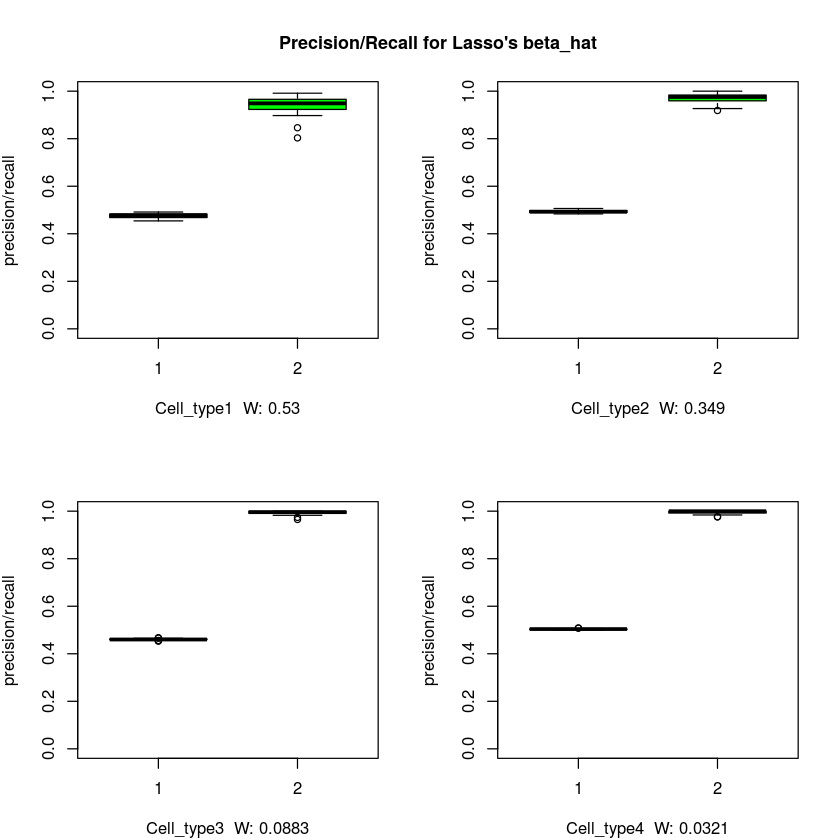

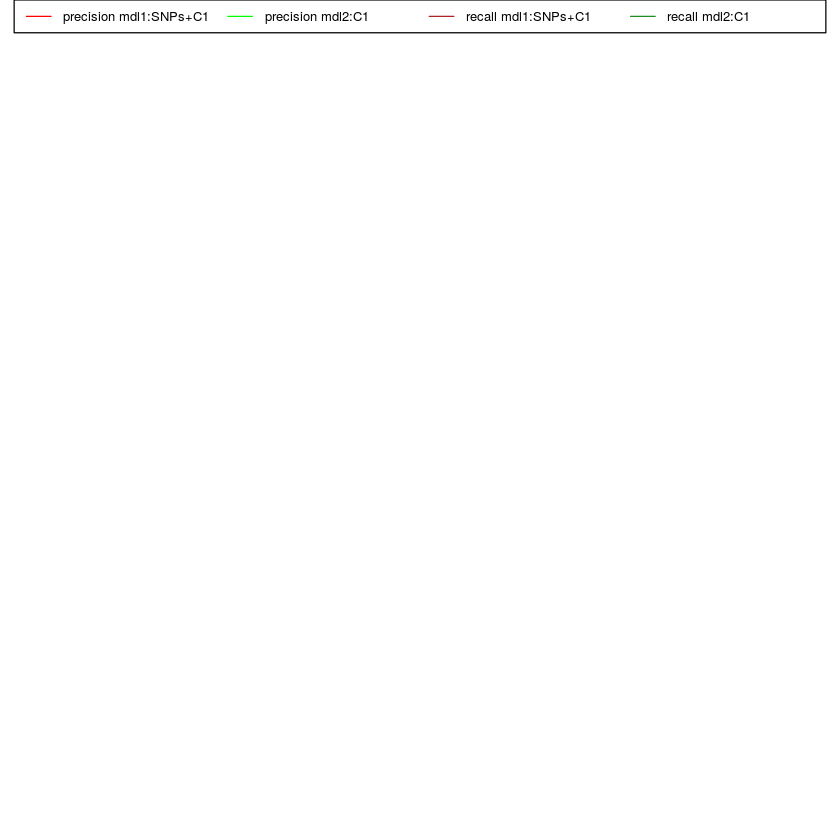

In [192]:
beta_precision_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$precision_lasso)),nrow=params$K)
#beta_precision_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$precision_lasso)),nrow=params$K)
beta_recall_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$recall_lasso)),nrow=params$K)
#beta_recall_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$recall_lasso)),nrow=params$K)
prec_rec_frame = lapply(1:params$K,function(x) t(rbind(beta_precision_lasso1[x,],beta_recall_lasso1[x,])))#,beta_recall_lasso1[x,],beta_recall_lasso2[x,])))

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=paste(params$cell_name,' W:',mean_weight)
for(i in 1:params$K){
    boxplot(prec_rec_frame[[i]],ylab='precision/recall',
        xlab=opts[i],boxwex=0.7,ylim=c(0,1),col=c('red','green','firebrick','forestgreen'))
}
mtext("Precision/Recall for Lasso's beta_hat",side=3,adj=12.5,cex=0.9,line=22.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('precision mdl1:SNPs+C1','precision mdl2:C1','recall mdl1:SNPs+C1','recall mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)

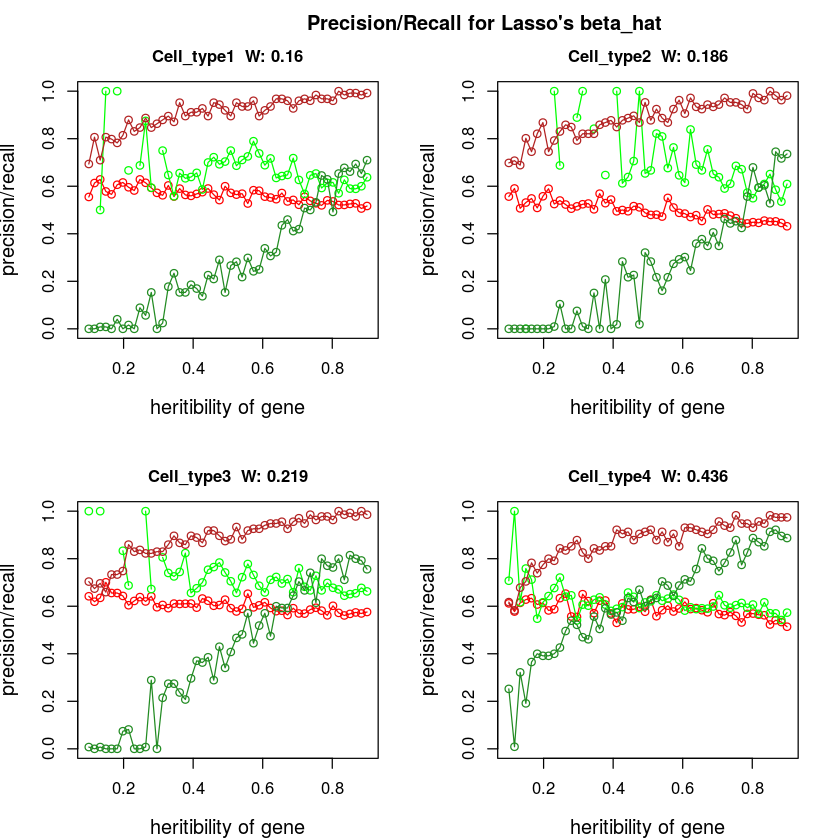

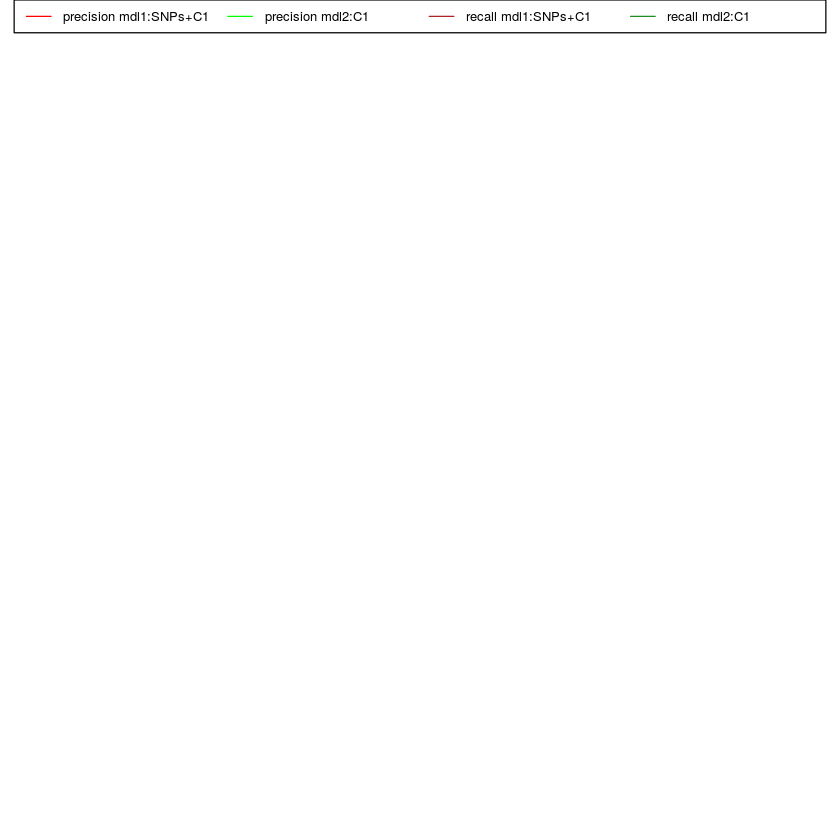

In [491]:
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
for(i in 1:params$K){
    plot(params$her[i,],prec_rec_frame[[i]][,1],xlab='heritibility of gene',
         ylab='precision/recall',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=opts[i],font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],prec_rec_frame[[i]][,2],col='green',type='o')
    lines(params$her[i,],prec_rec_frame[[i]][,3],col='firebrick',type='o')
    lines(params$her[i,],prec_rec_frame[[i]][,4],col='forestgreen',type='o')
}
mtext("Precision/Recall for Lasso's beta_hat",side=3,adj=3.5,cex=1,line=23.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('precision mdl1:SNPs+C1','precision mdl2:C1','recall mdl1:SNPs+C1','recall mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)

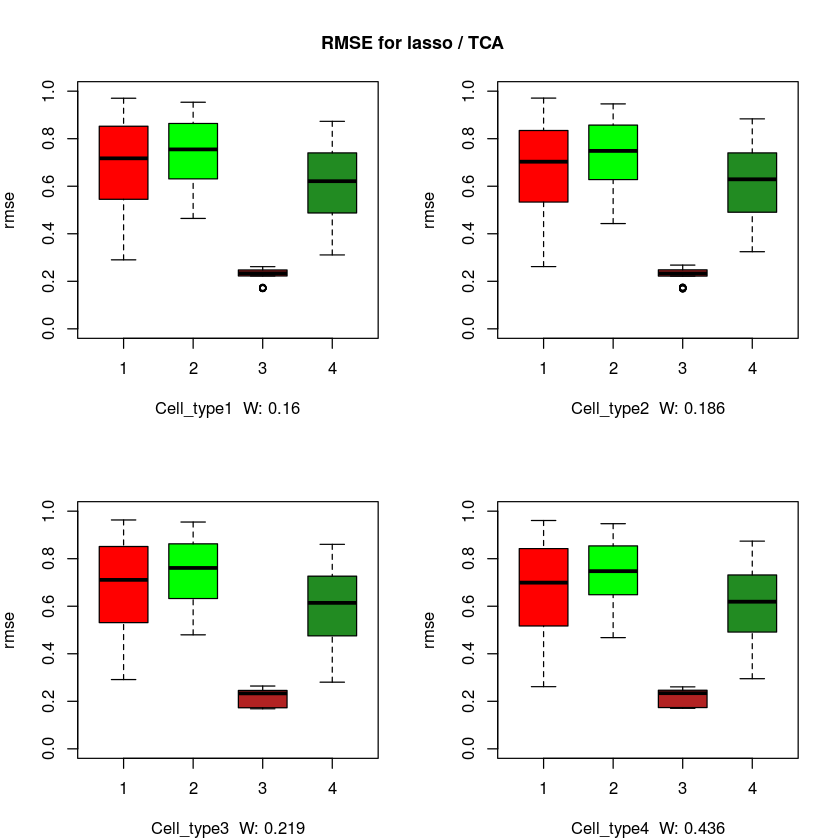

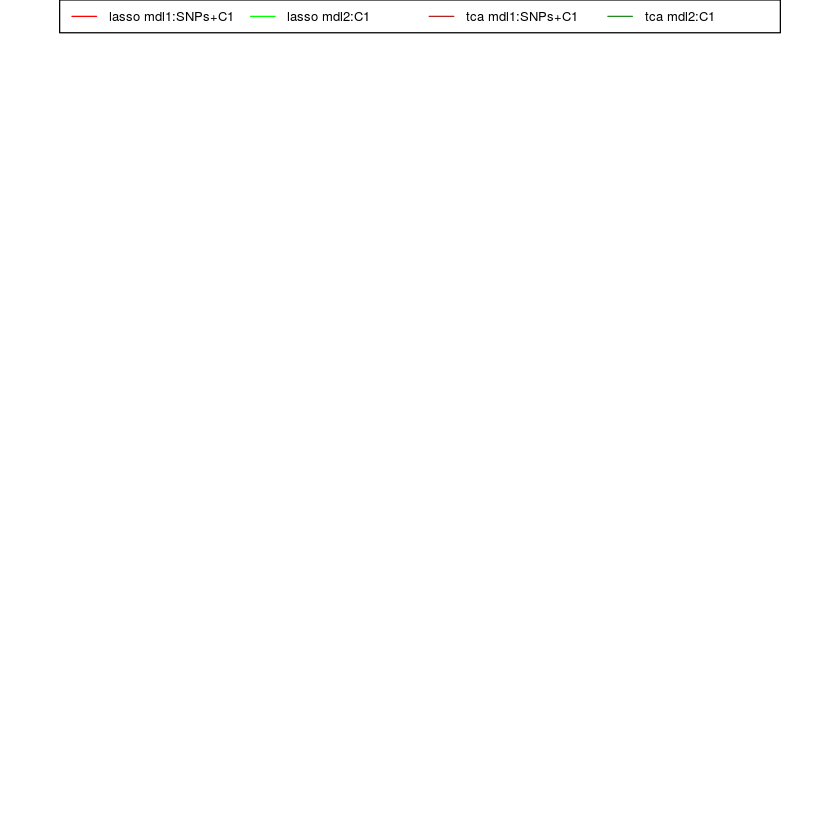

In [492]:
rmse_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$rmse_lasso)),nrow=params$K)
rmse_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$rmse_lasso)),nrow=params$K)
rmse_tca1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$rmse_tca)),nrow=params$K)
rmse_tca2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$rmse_tca)),nrow=params$K)
rmse_frame = lapply(1:params$K,function(x) t(rbind(rmse_lasso1[x,],rmse_lasso2[x,],rmse_tca1[x,],rmse_tca2[x,])))

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=paste(params$cell_name,' W:',mean_weight)
for(i in 1:params$K){
    boxplot(rmse_frame[[i]],ylab='rmse',
        xlab=opts[i],boxwex=0.7,ylim=c(0,1),col=c('red','green','firebrick','forestgreen'))
}
mtext("RMSE for lasso / TCA",side=3,adj=-1.5,cex=0.9,line=22.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('lasso mdl1:SNPs+C1','lasso mdl2:C1','tca mdl1:SNPs+C1','tca mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)